# Circuit EOMs
## Preamble
We have three sites in total and drive one externally. It reads (see summary):

\begin{equation}
  \begin{aligned}
    I_x &= \frac{1}{L_x} \Phi_x + 2 C_c \ddot \Phi_x - C_c \left( k_{x-1} \frac{\mathrm d}{\mathrm d t} \dot\Phi_{x-1}^\prime \dot\Phi_{x-1}
    + k_x \frac{\mathrm d}{\mathrm d t} \dot\Phi_x^\prime \dot\Phi_{x+1} \right) \\
    I_x^\prime &= \frac{1}{L_x^\prime} \Phi_x^\prime + 2 C_c \ddot \Phi_x^\prime - C_c k_x \frac{\mathrm d}{\mathrm d t} \dot\Phi_x \dot\Phi_{x+1}
  \end{aligned}
\end{equation}

To formulate using only first order derivatives, use voltages $V_i = \dot{\Phi}_i$.

\begin{equation}
  \begin{aligned}
    I_x &= \frac{1}{L_x} \Phi_x + 2 C_c \dot V_x - C_c \left( k_{x-1} \left(V_{x-1}^\prime \dot V_{x-1} + \dot V_{x-1}^\prime V_{x-1}\right)
    + k_x \left( V_x^\prime \dot V_{x+1} + \dot V_x^\prime V_{x+1} \right) \right) \\
    I_x^\prime &= \frac{1}{L_x^\prime} \Phi_x^\prime + 2 C_c \dot V_x^\prime - C_c k_x \left(V_x \dot V_{x+1} + \dot V_x V_{x+1} \right).
  \end{aligned}
\end{equation}

The integrator needs $\dot\Phi(\Phi, V, t)$ and $\dot V(\Phi, V, t)$.  The former is simply $\dot\Phi(\Phi, V, t)$, the latter we get from the equations above by writing $b(\Phi,I) = M(V) \cdot \dot V$ and inverting for $\dot V$.

The $2C_c$ in the on-site term are written $C$ to be separate coupling and on-site, even if this is not physically separate.

For a chain of length $L$, the index $x$ runs from 1 to $L$ for sites and from 1 to $L-1$ for links.  
Vectors are ordered $(\Phi_1, \Phi_1^\prime, \Phi_2, \Phi_2^\prime, \Phi_3, ...)$.

\begin{equation}
  \begin{pmatrix}
  I_1 - \Phi_1/L_1 \\
  I_1^\prime - \Phi_1^\prime/L_1^\prime \\
  I_2 - \Phi_2/L_2 \\
  I_2^\prime - \Phi_2^\prime/L_2^\prime \\
  I_3 - \Phi_3/L_3 \\
  \vdots \\
  I_L^\prime - \Phi_L^\prime/L_L^\prime \\
  I_L - \Phi_L/L_L
  \end{pmatrix}
  = \begin{pmatrix}
    C                  & C_c k_1 V_2 & C_c k_1 V_1^\prime \\
    C_c k_1 V_2        & C           & C_c k_1 V_1        \\
    C_c k_1 V_1^\prime & C_c k_1 V_1 & C                  & C_c k_2 V_3 & C_c k_2 V_2^\prime \\
                       &             & C_c k_2 V_3        & C           & C_c k_2 V_2        \\
                       &             & C_c k_2 V_2^\prime & C_c k_2 V_2 & C                  & \\
                       &             &                    &             &                    & \ddots & \\
    & & & & & & C_c k_{L-1} V_{L}          & C                   & C_c k_{L-1} V_{L-1
} \\
    & & & & & & C_c k_{L-1} V_{L-1}^\prime & C_c k_{L-1} V_{L-1} & C
  \end{pmatrix}
  \cdot
  \dot V
\end{equation}

Local charges are given by
\begin{equation}
  G_x = (-1)^x E_{x-1}^\prime + E_x + (-1)^x E_x^\prime
\end{equation}
where resonator energies are
\begin{equation}
  E = \frac{1}{2L}\Phi^2 + \frac{1}{2C} Q^2 = \frac{1}{2L}\Phi^2 + \frac{C}{2} V^2
\end{equation}

Furthermore global energy  $E_\text{glob} = \sum E_x$ is conserved due to U(1) and total energy $E_\text{tot} = \sum E_x + \sum E_x^\prime$ is conserved if Hamiltonian is independent of time (no driving).

## Simulation

In [5]:
import numpy as np

from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook


def dotV(phi, V, I, L, C, Cc, k):
    """Calculate dotV by inverting equations of motion.
    
    phi, V, I and L are of length n=2l-1,
    C is broadcast to n=2l-1,
    k is of length l-1,
    Cc is scalar.
    """
    # number of resonators, always uneven
    n = len(phi) # = l + l-1
    # length of chain
    l = (n + 1) // 2

    # broadcast some quantities
    assert np.isscalar(Cc)
    k = np.broadcast_to(k, l-1)

    # build linear system of equations
    M = np.diag(np.broadcast_to(C, n))
    # first right off-diagonal, length n-1 = 2l - 2 = (l-1) * 2, even
    d = Cc * np.repeat(k, 2)
    d[::2] *= V[2::2] # V2, V3, V4, Vl, ... length: l-1
    d[1::2] *= V[:-2:2] # V1, V2, V3, ... V(l-1) length: l-1
    M += np.diag(d, k=1)
    # first left off-diagonal
    d = Cc * np.repeat(k, 2)
    d[::2] *= V[2::2]
    d[1::2] *= V[:-2:2]
    M += np.diag(d, k=-1)
    # second right off-diagonal, length n-2
    d = np.zeros(n-2)
    # (n - 2 + 1) / 2 = (l + l - 1 - 1) / 2 = (2l - 2) / 2 = l-1
    d[::2] = Cc * k * V[1::2] # Cc k V1', Cc k V2', CC k V3', ... length l-1
    M += np.diag(d, k=2)
    # second left off-diagonal
    d = np.zeros(n-2)
    d[::2] = Cc * k * V[1::2]
    M += np.diag(d, k=-2)

    b = I - phi / L
    return np.linalg.solve(M, b)


def eom(y, t, I0, Iω, L, C, Cc, k):
    """eom = dydt, where y = (Phi, V)"""
    n = len(L)
    I = I0 * np.cos(Iω * t)
    return np.concatenate([
        y[n:],
        dotV(y[:n], y[n:], I, L, C, Cc, k)
    ]) # = dydt


def run_onepoint(ts, fs, Iamp, If, Ii=0, V0=None,
                 C=20e-9, Cc=10e-9, k=1/10):
    """
    Returns tuple with (
           phi of shape (steps, n),
         np.concatenate  V of shape(steps, n)
       )
    """
    n = len(fs)
    
    omegas = 2*np.pi * fs # 1/s
    L = 1 / (omegas**2 * C) # Henry
    # external current
    I0, Iω = np.zeros(n), np.zeros(n)
    I0[Ii] = Iamp
    Iω[Ii] = 2*np.pi * If
    
    # initial state
    if V0 is None:
        V0 = np.repeat(1, n) # 1 V
    y0 = np.concatenate([
        np.repeat(0, n), # phi0 = 0 [Weber]
        V0,
    ])
    y0[n+1] = 1.2
    
    sol, out = odeint(eom, y0, ts, args=(I0, Iω, L, C, Cc, k), full_output=True)
    if np.any((out['mused'] < 1) | (out['mused'] > 2)):
        sol[:,:] = np.nan
    return sol[:,:n], sol[:,n:], L

def spectrum(signal, samplespacing):
    """Calculate spectrum [V/Hz] along last axis."""
    fbins = rfftfreq(signal.shape[-1], samplespacing)
    fft = np.absolute(rfft(signal * np.hamming(signal.shape[-1])[...,np.newaxis], axis=-1) * samplespacing)
    return fbins, fft

def energies(phi, V, L, C=20e-9):
    C = np.broadcast_to(C, L.shape)
    E = phi**2 / L[np.newaxis,:] / 2 + C[np.newaxis,:] * V**2 / 2
    Etot = np.sum(E, axis=-1)
    return E, Etot

def Gtot(E, fs, f0=60e3):
    ωbar = fs / f0
    return np.sum(E[...,::2] / ωbar[...,::2], axis=-1)

def Gxs(E, fs, f0=60e3):
    ωbar = fs / f0
    Eprime = E / ωbar
    # alternating signs
    n = E.shape[1]
    l = (n + 1) // 2
    sign = np.tile([-1, 1], l)[:l]

    Elink = Eprime[:,1::2] # length l-1
    G = Eprime[:,::2] # length l
    G[:,:-1] += sign[:-1] * Elink
    G[:,1:] += sign[1:] * Elink
    return G

In [ ]:
#def plot_spectrum()

## Single run

<IPython.core.display.Javascript object>


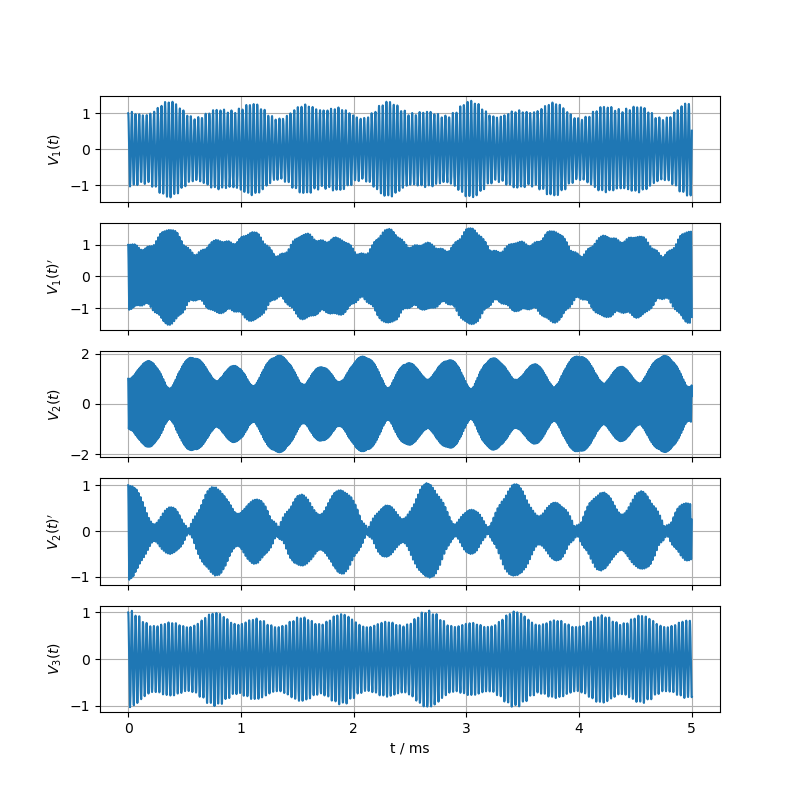

<IPython.core.display.Javascript object>


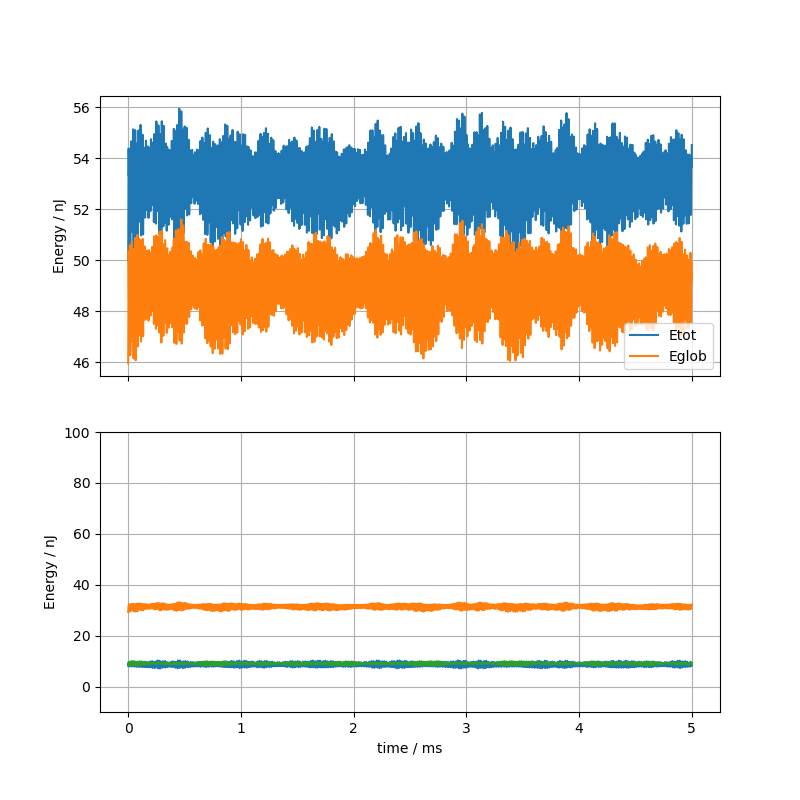

In [226]:
tlin = np.linspace(0, 5e-3, 5000)
fs = np.array([30.98e3, 53.44e3, 84.32e3, 54.68e3, 30.80e3])
Iamp, If = 0e-3, 29e3
phi, V, L = run_onepoint(tlin, fs, Iamp, If, Ii=0)

f, axs = plt.subplots(nrows=len(fs), sharex=True, figsize=(8,8))
for i, f in enumerate(fs):
    axs[i].plot(tlin*1e3, V[:, i])
    axs[i].set_ylabel(r'$V_%d(t)'%(i//2+1)+(r'^\prime' if i%2==1 else '')+'$')
    axs[i].grid()
axs[-1].set_xlabel('t / ms')

tcirc = tlin
Ecirc, Etotcirc = E, Etot = energies(phi, V, L, C=20e-9)
Gtotcirc = Eglob = Gtot(E, fs)
Gcirc = G = Gxs(E, fs)

f, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax1.plot(tlin*1e3, Etot*1e9, label='Etot')
ax1.plot(tlin*1e3, Eglob*1e9, label='Eglob')
ax2.plot(tlin*1e3, G*1e9)
ax1.legend()
ax1.grid(), ax2.grid()
ax1.set_ylabel('Energy / nJ')
ax2.set_ylabel('Energy / nJ')
ax2.set_xlabel('time / ms')

ax2.set_ylim(-10, 100);

<IPython.core.display.Javascript object>


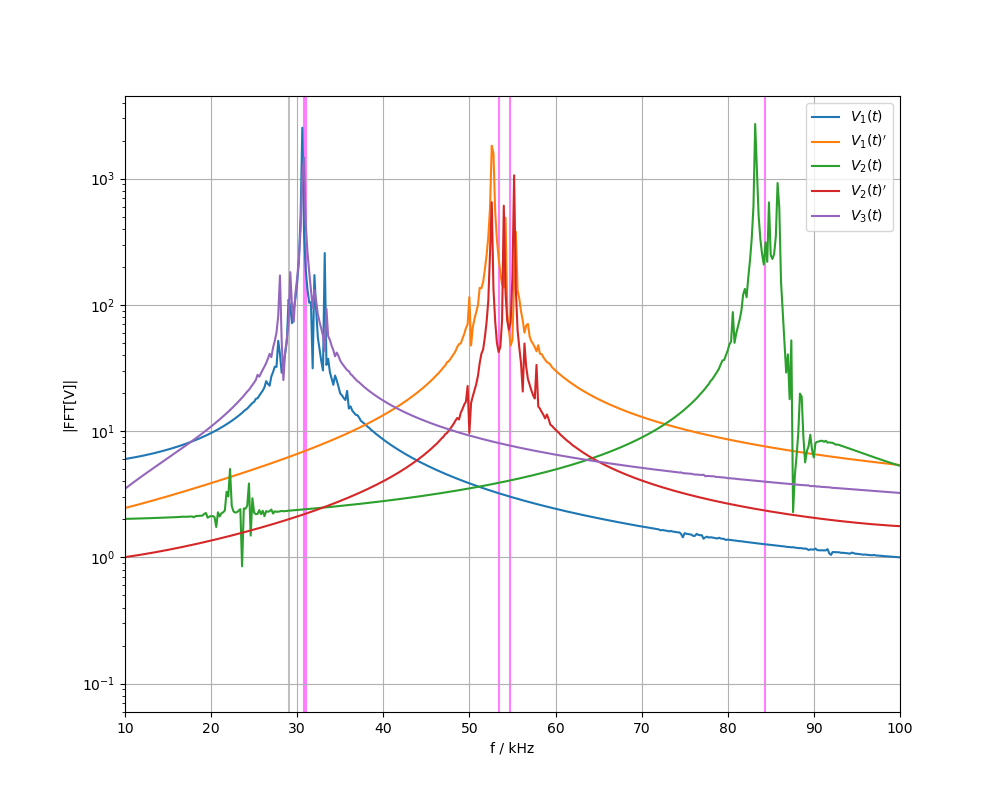

In [6]:
from scipy.fft import rfft, rfftfreq

plt.figure(figsize=(10, 8))

fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))
for i in range(len(fs)):
    plt.plot(fbins/1e3, np.absolute(rfft(V[:,i], n=len(tlin))),
             label=r'$V_%d(t)'%(i//2+1)+(r'^\prime' if i%2==1 else '')+'$')

plt.axvline(If/1e3, color='silver', zorder=-1)
for f in fs:
    plt.axvline(f/1e3, color='fuchsia', zorder=-1, alpha=0.5)

plt.yscale('log')
plt.xlabel('f / kHz')
plt.ylabel('|FFT[V]|')
plt.legend()
plt.grid()
plt.xlim(10, 100);

## Scan all fδ

In [ ]:
from scipy.fft import rfft, rfftfreq

l = 3
fδs = np.linspace(-3e3, 3e3, 11)

def fs(fδ):
    f = np.zeros((*fδ.shape, 2*l-1))
    f[...,0::4] = 30e3
    f[...,2::4] = 90e3
    f[...,1::2] = 60e3 + fδ[...,np.newaxis]
    return f

Iamp, If = 0/180, 30e3

tlin = np.linspace(0, 8e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

resultV = np.array([
    run_onepoint(tlin, fs(fδ), Iamp, If, k=1/10)[1] for fδ in fδs
])

tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


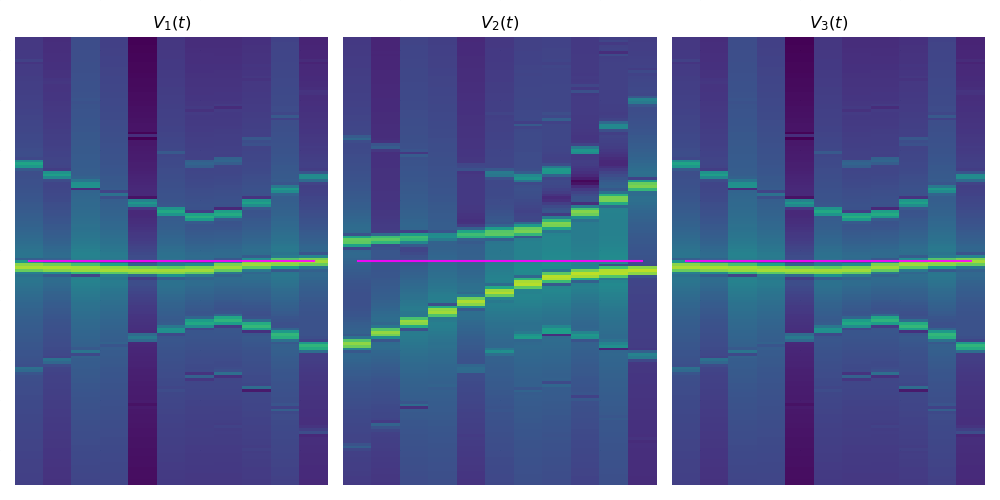

In [15]:
frange = 10e3
vmin, vmax = -7, -2

fig, axs = plt.subplots(ncols=l, sharex=True, figsize=(10, 5))
for i in range(l):
    axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, np.log10(fftV[:, :, 2*i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    f0 = fs(fδs)[:,2*i]
    axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}(t)'%(i+1)+'$')
    axs[i].set_xlabel('fδ / kHz')
    axs[i].grid()
    axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


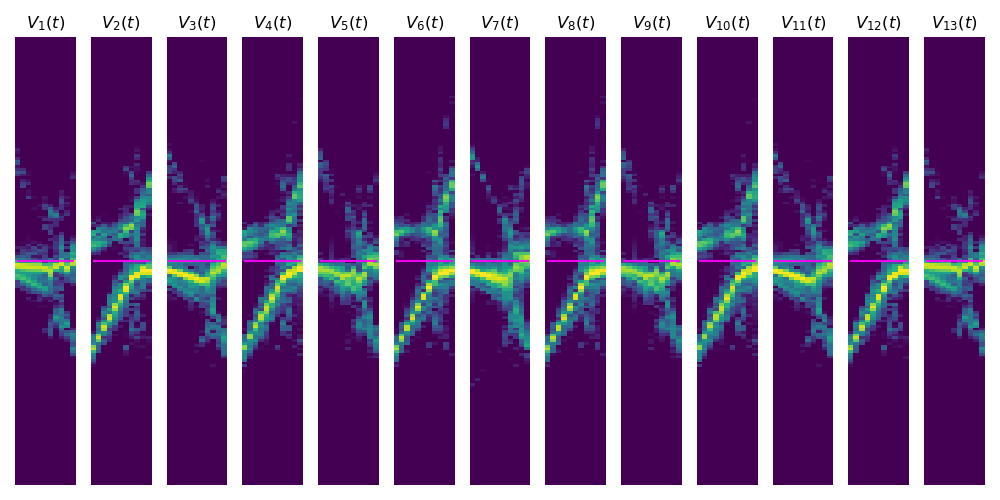

In [7]:
fig, axs = plt.subplots(ncols=l, sharex=True, figsize=(10, 5))
for i in range(l):
    axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, np.log10(fftV[:, :, 2*i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    f0 = fs(fδs)[:,2*i]
    axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}(t)'%(i+1)+'$')
    axs[i].set_xlabel('fδ / kHz')
    axs[i].grid()
    axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

## Scan one fδ

In [6]:
from scipy.fft import rfft, rfftfreq

l = 3
fδs = np.linspace(-3e3, 3e3, 20)

def fs(fδ, fδother=0e3):
    f = np.zeros((*fδ.shape, 2*l-1))
    f[...,0::4] = 30e3 # odd sites
    f[...,2::4] = 90e3 # even sites
    # links
    f[...,1] = 60e3 + fδ
    f[...,3::2] = 60e3 + fδother
    return f

Iamp, If = 0/180, 30e3

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

resultphi, resultV, resultL = [], [], []
for fδ in fδs:
    phi, V, L = run_onepoint(tlin, fs(fδ), Iamp, If, k=1/10)
    resultphi.append(phi), resultV.append(V), resultL.append(L)
resultphi, resultV, resultL = np.array(resultphi), np.array(resultV), np.array(resultL)

tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

In [229]:
resultV.shape, resultL.shape

((20, 3000, 5), (20, 5))

<IPython.core.display.Javascript object>


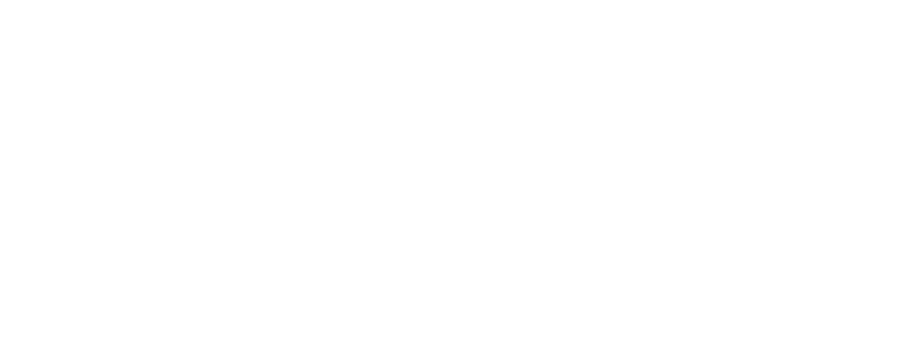

In [315]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs(fδs)[:,i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('$f_{\delta 1}$ / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')
plt.savefig('/home/hannes/plot.png', dpi=500)

### Conservation

In [304]:
fs(fδs[fδidx])

array([30000.        , 61105.26315789, 90000.        , 60000.        ,
       30000.        ])

1105.2631578947367


<IPython.core.display.Javascript object>


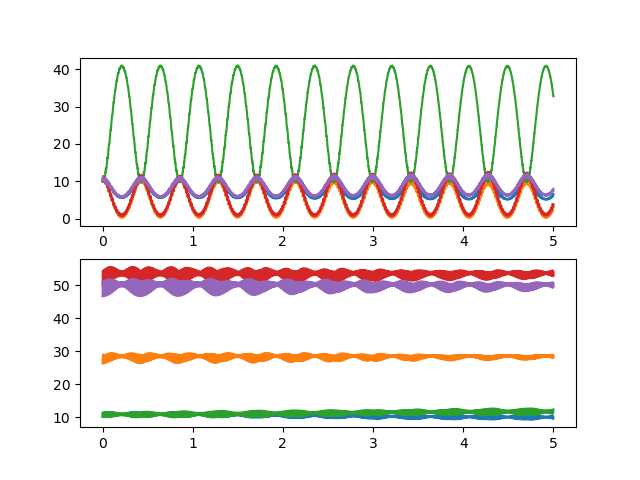

In [300]:
fδidx = 13
print(fδs[fδidx])

tcirc = tlin
Ecirc, Etotcirc = E, Etot = energies(resultphi[fδidx], resultV[fδidx], resultL[fδidx], C=20e-9)
Gtotcirc = Eglob = Gtot(E, fs(fδs[fδidx]))
Gcirc = G = Gxs(E, fs(fδs[fδidx]))

fig, axs = plt.subplots(nrows=2)
axs[0].plot(tlin*1e3, Ecirc*1e9, '-')
axs[1].plot(tlin*1e3, Gcirc*1e9, '-')
axs[1].plot(tlin*1e3, Etotcirc*1e9, '-')
axs[1].plot(tlin*1e3, Gtotcirc*1e9, '-')

## Scan f_Idrive

In [75]:
fs = np.array([30.98e3, 53.44e3, 84.32e3, 54.86e3, 30.80e3])
Iamp = 0.02/180
Ifs = np.linspace(27e3, 35e3, 35)

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

V0 = np.array([0, 1, 1, 1, 1])
resultV = np.array([
    run_onepoint(tlin, fs, Iamp, If, V0=V0, k=1/10)[1] for If in Ifs
])

In [79]:
tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


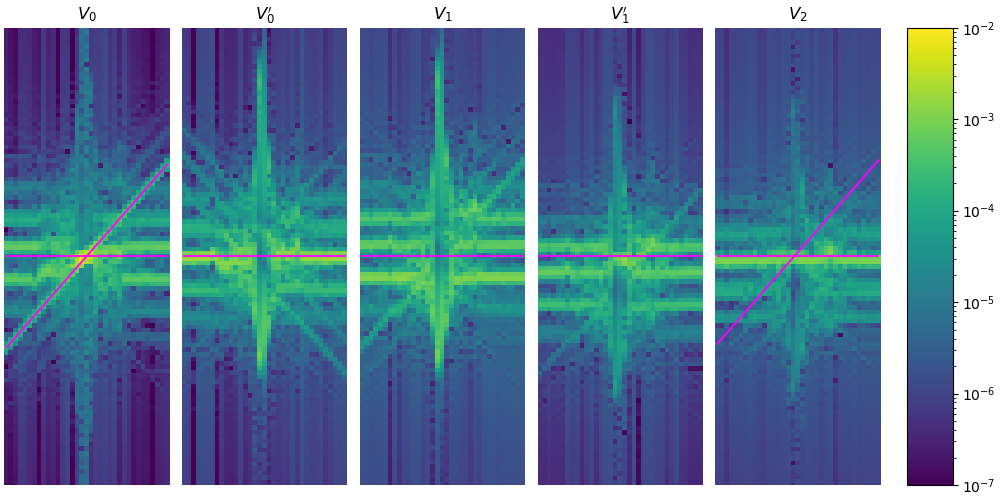

In [80]:
frange = 10e3
vmin, vmax = 1e-7, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, sharex=True, figsize=(10, 5), constrained_layout=True)
for i in range(n):
    im = axs[i].pcolormesh(
        Ifs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap='viridis', shading='auto')
    f0 = fs[i]
    axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('fδ / kHz')
    axs[i].grid()
    axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs)
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


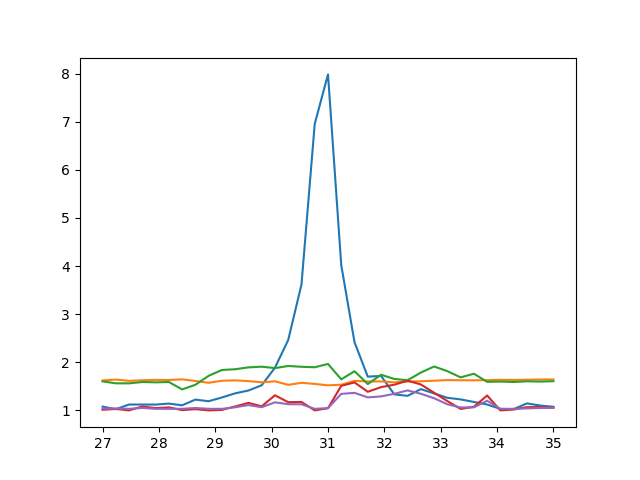

In [81]:
plt.figure()
for p in range(resultV.shape[-1]):
    plt.plot(Ifs/1e3, np.max(resultV[...,p], axis=1))

## 11-23 Set 2

In [316]:
fs = np.array([31.05e3, 55.31e3, 85.03e3, 56.48e3, 30.88e3])
Iamp = 0.05/180
Ifs = np.linspace(24e3, 36e3, 35)

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

V0 = np.array([1, 1, 1, 1, 1])
resultV = np.array([
    run_onepoint(tlin, fs, Iamp, If, V0=V0, k=1/10)[1] for If in Ifs
])

/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [317]:
tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


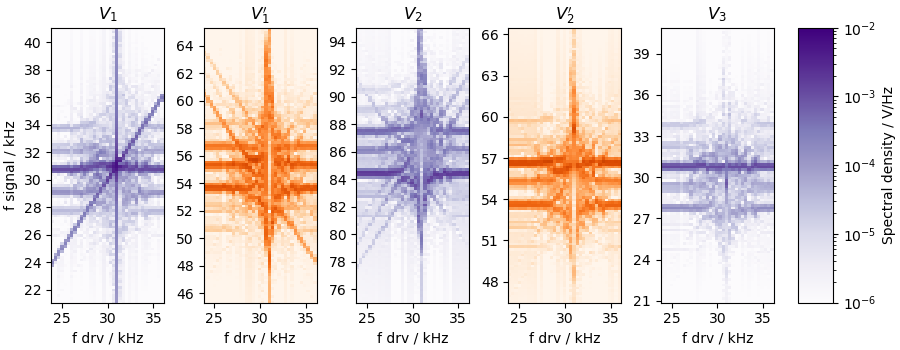

In [319]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        Ifs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs[i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('f drv / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')
plt.savefig('/home/hannes/plot.png', dpi=500)

## 11-24 Set 3
Note: for this set the initializer of site 1 was disconnected

In [106]:
fs = np.array([31.78e3, 55.59e3, 84.39e3, 56.57e3, 30.84e3])
Iamp = 0.05/180
Ifs = np.linspace(24e3, 36e3, 35)

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

V0 = np.array([0, 1, 1, 1, 1])
resultV = np.array([
    run_onepoint(tlin, fs, Iamp, If, V0=V0, k=1/10)[1] for If in Ifs
])

In [107]:
tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


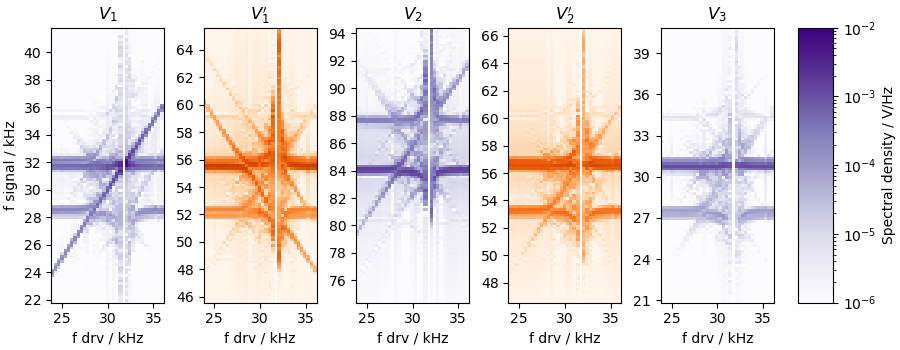

In [108]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        Ifs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs[i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('f drv / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')
plt.savefig('/home/hannes/plot.png', dpi=500)

# Estimations

In [219]:
import numpy as np
import quantities as pq # TODO not avaiable in virt env!!!

fs = np.array([30.80, 54.47, 84.32]) * pq.Hz
Cc = 10e-9 * pq.F
Cs = np.array([20e-9, 20e-9, 20e-9]) * pq.F
Ls = (1/((2*np.pi*fs)**2 * Cs)).rescale('H')

print("f", fs)
print("L", Ls)

ωs = 2*np.pi * fs
V0 = 1 * pq.V

Is = (np.sqrt(Cs / Ls) * V0).rescale('A')
print("I", Is)

Q = Cs * V0
print("Q", Q, "(Coulomb)")

Φ = Ls * Is
print("Φ", Φ, "(Weber)")

Φtilde = (Φ / np.sqrt(2*ωs * Ls)).rescale('(J*s)**0.5')
Qtilde = (Q / np.sqrt(2*ωs * Cs)).rescale('(J*s)**0.5')
Es = (ωs/2 * (Φtilde**2 + Qtilde**2)).rescale('J')

print('Qtilde', Qtilde, '(sqrt Js)')
print('Φtilde', Φtilde, '(sqrt Js)')
print('E = H_0 = ω a* a =', Es)
print()

# |a| = sqrt(a* a)
a = np.sqrt((Φtilde**2 + Qtilde**2)/2)
print("a", a)

k = 1/(10 * pq.V) # 1/V
λ = k * np.prod(ωs)**0.5 / (2**3 * np.sqrt(Cc))
print(f"λ {λ.rescale('1/(J*s**3)**0.5'):.2e}")

Hint = (λ * np.prod(a)).rescale('J')
print(f"Hint {Hint:.2e}")

Q0
Ω = (λ * a).rescale('1/s')
print(f"possible Ω", Ω)

f [30.8  54.47 84.32] Hz
L [1335.0847482   426.86988498  178.13492361] H
I [3.87044215e-06 6.84490207e-06 1.05959637e-05] A
Q [2.e-08 2.e-08 2.e-08] V*F (Coulomb)
Φ [0.00516737 0.00292188 0.00188751] A*H (Weber)
Qtilde [7.18844092e-06 5.40544407e-06 4.34454967e-06] s**0.5*J**0.5 (sqrt Js)
Φtilde [7.18844092e-06 5.40544407e-06 4.34454967e-06] s**0.5*J**0.5 (sqrt Js)
E = H_0 = ω a* a = [1.e-08 1.e-08 1.e-08] J

a [7.18844092e-06 5.40544407e-06 4.34454967e-06] s**0.5*J**0.5
λ 7.40e+05 1/(s**1.5*J**0.5)
Hint 1.25e-10 J
possible Ω [5.32272303 4.00249261 3.21694716] 1/s


# Hamiltonian

The Hamiltonian in dimensionless complex variables:
$$
  H(a, a^*) = \frac{-\Delta}{2} \sum_{x=1}^l (-1)^x a_x^* a_x
  + \Omega \sum_{x=1}^{l-1} \begin{cases}
    a_x^* b_x^* a_{x+1} + \text{H.c.} & \text{for $x$ odd,} \\
    a_x^* b_x a_{x+1} + \text{H.c.} & \text{for $x$ even.}
  \end{cases}$$

has the equations of motion
$$\dot a_x = i\frac{\partial H}{\partial a^*} = -i \frac{\Delta}{2} (-1)^x a_x +i \Omega \begin{cases}
  b_{x-1}^* a_{x-1} + b_x^* a_{x+1} & \text{for $x$ odd},\\
  b_{x-1} a_{x-1} + b_x a_{x+1} & \text{for $x$ even}.
\end{cases} $$
$$\dot b_x = i\frac{\partial H}{\partial a^*} = i \Omega \begin{cases}
  a_x^* a_{x+1} & \text{for $x$ odd},\\
  a_x a_{x+1}^* & \text{for $x$ even}.
\end{cases} $$

**Note:** indexing here is from 1 to l, but from code from 0 to l-1.

## Simulation
Implement function for derivatives of complex variables:

In [7]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook


class RangeViolation(Exception):
    def __init__(self, time, msg=None):
        self.simulationtime = time
        if msg is None:
            msg = f"One variable outside range at time {time}."
        super().__init__(msg)


def Ibar(Iext, f, C=20e-9, ω0=60e3, V0=1):
    L = 1 / ((2*np.pi * f)**2 * C)
    ωbar = 2*np.pi * f / ω0
    return Iext / V0 * np.sqrt(L / (2 * ωbar * C))


def eom(y, t, Δ, Ω, Iω=None, Ibar=0, rangelimit=np.inf, dtype=complex):
    """eom = dydt, where y = (a1, b1, a2 b2, ...)
    Works only for l uneven!
    Time is also dimensionless as y is dimensionless!
    Also Ibar is dimensionless.
    Iω is terms of dimensionless time.
    """
    if np.isfinite(rangelimit) and np.any(np.absolute(y) > rangelimit):
        raise RangeViolation(t)
    a, b = y[::2], y[1::2]

    dota = -1j * Δ/2 * a # -i Δ/2 a
    dota[::2] *= -1 # (-1)^x
    dota[2::2] += 1j * Ω[1::2] * np.conj(b[1::2]) * a[1::2] # x odd
    dota[:-1:2] += 1j * Ω[::2] * np.conj(b[::2]) * a[1::2] # x odd
    dota[1::2] += 1j * Ω[::2] * (b[::2] * a[:-1:2] + b[1::2] * a[2::2]) # x even
    dotb = np.zeros(b.shape, dtype)
    dotb[::2] = 1j * Ω[::2] * np.conj(a[:-1:2]) * a[1::2] # x odd
    dotb[1::2] = 1j * Ω[1::2] * np.conj(a[2::2]) * a[1:-1:2] # x even
    doty = np.zeros(y.shape, dtype)
    doty[::2] = dota
    doty[1::2] = dotb

    if Iω is not None:
        doty -= Ibar * np.sin(Iω * t)

    return doty


def Vtoain(V, fs, V0=1, f0=60e3):
    return 1j / (2 * fs / f0)**0.5 * V/V0

def ftoΔ(fs, f0=60e3):
    """Convert frequencies of chain (along last axis) to dimensionless Δ."""
    ωsites = fs[...,::2] / f0
    ωlinks = fs[...,1::2] / f0
    print(fs.shape, ωlinks.shape, ωsites.shape)
    δ = [ωlinks[...,i] - (-1)**(i+1) * (ωsites[...,i] - ωsites[...,i+1]) for i in range(ωlinks.shape[-1])]
    Δ = [δ[0]] + δ # first and second Δ1 = Δ2 = δ1
    # concatenate along last axis
    return np.concatenate([d[...,np.newaxis] for d in Δ], axis=len(fs.shape)-1)

def atoV(a, fs, V0=1, f0=60e3):
    return (2 * fs / f0)**0.5 * a.real * V0

def ftoΩ(fs, Vref, V0=1, f0=60e3):
    ωsites = fs[...,::2] / f0
    ωlinks = fs[...,1::2] / f0
    Ωs = [(ωsites[...,i] * ωlinks[...,i] * ωsites[...,i+1] / 2**5)**0.5 * V0/Vref for i in range(ωlinks.shape[-1])]
    # concatenate along last axis
    return np.concatenate([Ω[...,np.newaxis] for Ω in Ωs], axis=len(fs.shape)-1)


from scipy.integrate import odeint

def complex_odeint(func, y0, ts, args=(), full_output=0, printmessg=0):
    """Wrap odeint for complex valued functions."""
    n = len(y0)
    flaty0 = np.concatenate([np.real(y0), np.imag(y0)])
    def flatfunc(flaty, t, *args):
        dy = func(flaty[:n] + 1j * flaty[n:], t, *args)
        return np.concatenate([np.real(dy), np.imag(dy)])
    out = odeint(flatfunc, flaty0, ts, args,
                 full_output=full_output, printmessg=printmessg)
    if type(out) is tuple:
        return out[0][:,:n]+1j*out[0][:,n:], *out[1:]
    else:
        return out[:,:n] + 1j*out[:,n:]

def run_complex(ts, y0, *args):
    """
    Returns y of shape (steps, 2l-1)
    """
    ys, out = complex_odeint(eom, y0, ts, args=args, full_output=True)
    if np.any((out['mused'] < 1) | (out['mused'] > 2)):
        ys[:,:] = np.nan
    else:
        assert np.allclose(ys[0,:], y0)
    return ys


def Gtot(ys):
    G = np.sum(np.conj(ys[...,::2]) * ys[...,::2], axis=-1)
    assert np.allclose(G.imag, 0)
    return G.real

def Gx(ys, x): # x starting from 1
    i = x - 1 # i starting from 0
    G = np.conj(ys[...,2*i]) * ys[...,2*i]
    if 2*i > 0:
        G += (-1)**x * np.conj(ys[...,2*i-1]) * ys[...,2*i-1]
    if 2*i < ys.shape[-1]-1:
        G += (-1)**x * np.conj(ys[...,2*i+1]) * ys[...,2*i+1]
    assert np.allclose(G.imag, 0)
    return G.real

## Check the implementation using symbolic evaluation:

In [64]:
import sympy
from sympy import symbols
sympy.init_printing()

l = 5
a = symbols(['a_%d'%i for i in range(l)], real=False)
b = symbols(['b_%d'%i for i in range(l-1)], real=False)

symy = np.zeros(2*l-1, dtype=object)
symy[::2] = a
symy[1::2] = b

In [65]:
res = eom(symy, 0, Δ=1, Ω=1, dtype=object)
for i, r in enumerate(res):
    if i % 2 == 0:
        display(sympy.Eq(a[i//2], r))
    else:
        display(sympy.Eq(b[i//2], r))

## Try a single run
Without external driving:

<IPython.core.display.Javascript object>


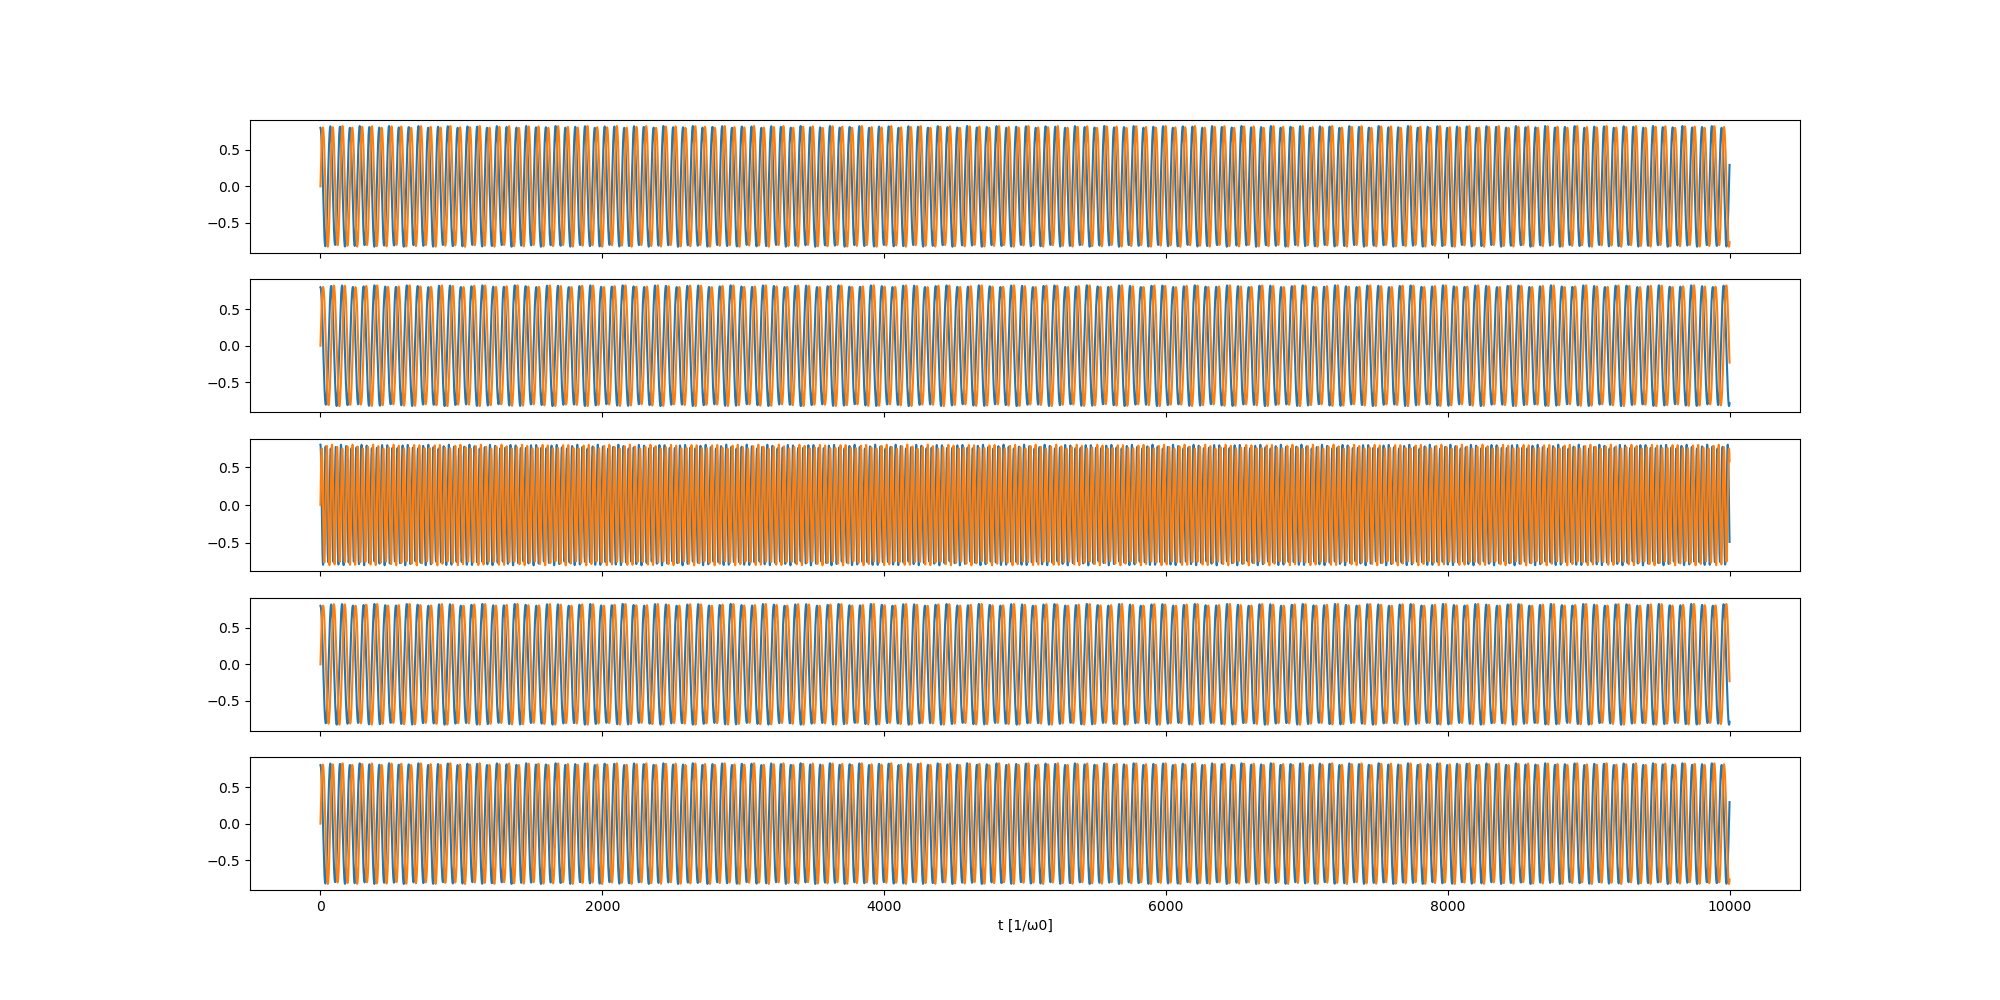

In [3]:
l = 3
ts = np.linspace(0, 10000, 100000)
Δ, Ω = 1e3/60e3, 0.106

y0 = 0.8 * np.full(2*l-1, 1, dtype=complex)
#y0 = np.exp(1j * np.random.uniform(0, 2*np.pi, 2*l-1))

ys = run_complex(ts, y0, Δ, Ω)

fig, axs = plt.subplots(nrows=ys.shape[1], figsize=(20, 10), sharex=True)
for i in range(ys.shape[1]):
    axs[i].plot(ts, np.real(ys[:,i]), color='C0')
    axs[i].plot(ts, np.imag(ys[:,i]), color='C1')
axs[-1].set_xlabel('t [1/ω0]');

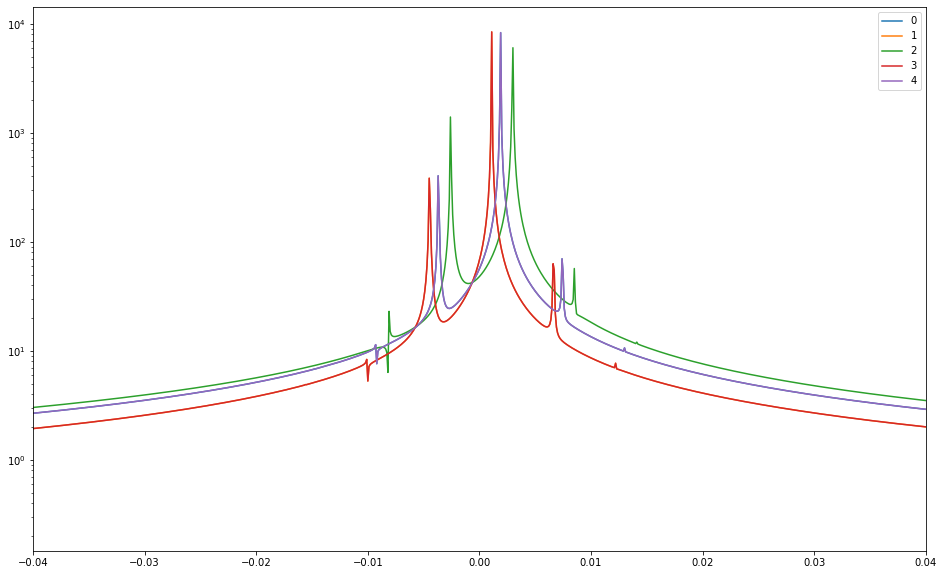

In [42]:
from scipy.fft import fft, fftfreq, fftshift

fftys = np.absolute(fftshift(fft(ys, axis=0), axes=0))
freqbins = fftshift(fftfreq(ys.shape[0]))

fig = plt.figure(figsize=(16,10))
for i in range(ys.shape[1]):
    plt.plot(freqbins, fftys[:,i], label=i)
plt.xlim(-0.04, 0.04)
plt.yscale('log')
plt.legend();

With external driving

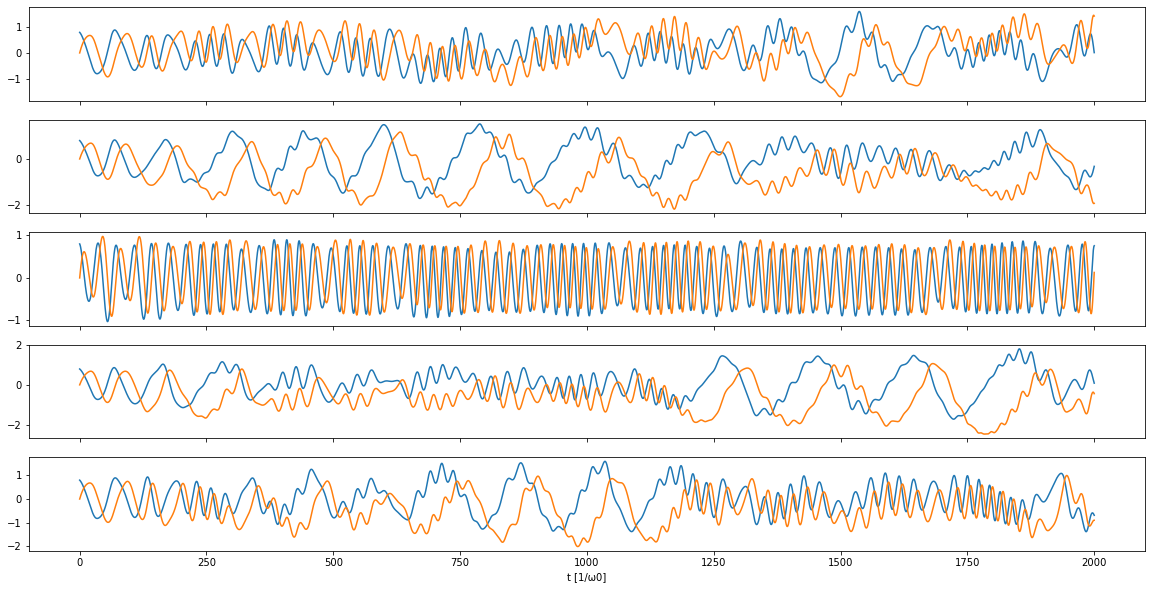

In [175]:
l = 3
ts = np.linspace(0, 2000, 10000)
Δ = 1e3 / 60e3
Ω = 0.106

Iext = 0.2e-3 # mA
# Drive only first site
Iωs = np.zeros(2*l-1)
Iωs[0] = 0.5e3 / 60e3

y0 = np.full(2*l-1, 0.8, dtype=complex)
#y0 = np.exp(1j * np.random.uniform(0, 2*np.pi, 2*l-1))

ys = run_complex(ts, y0, Δ, Ω, Iωs, Ibar(Iext, 30e3), 5)

fig, axs = plt.subplots(nrows=ys.shape[1], figsize=(20, 10), sharex=True)
for i in range(ys.shape[1]):
    axs[i].plot(ts, np.real(ys[:,i]), color='C0')
    axs[i].plot(ts, np.imag(ys[:,i]), color='C1')
axs[-1].set_xlabel('t [1/ω0]');

## Scan Δ

In [248]:
from scipy.fft import fft, fftfreq, fftshift

l = 3
Ω = 0.106
Δs = np.linspace(-2, 2, 40)

ts = np.linspace(0, 1000, 10000)

"""
a0 = np.full(l, 1, dtype=complex)
b0 = np.tile([0.5, 1], l//2).astype(complex)
y0 = np.zeros(2*l-1, dtype=complex)
y0[::2] = a0
y0[1::2] = b0
"""
y0 = np.full(2*l-1, 1, dtype=complex)

ys = np.array([run_complex(ts, y0, Δ, Ω) for Δ in Δs])
print(ys.shape)

fftys = np.absolute(fftshift(fft(ys * np.hamming(ys.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
fftbins = fftshift(fftfreq(ys.shape[1]))

(40, 10000, 5)


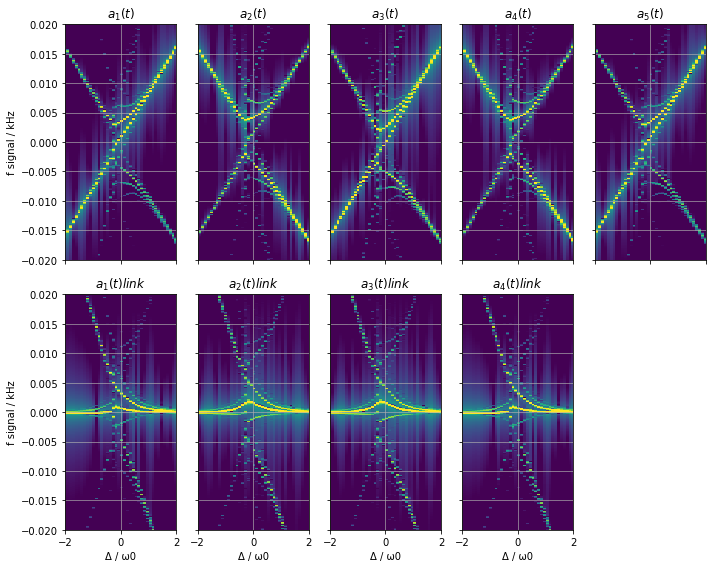

In [244]:
vmin, vmax = 0.2, 3

fig, axs = plt.subplots(nrows=2, ncols=l, figsize=(10, 8), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    x = i//2 # 0 offset
    link = i % 2
    axs[link,x].pcolormesh(
        Δs, fftbins, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[link,x].set_ylim(-0.02, 0.02)
    axs[link,x].set_xlim(np.min(Δs), np.max(Δs))
    axs[link,x].set_title(f"$a_{i//2+1}(t){'link' if i%2==1 else ''}$")
    if link:
        axs[link,x].set_xlabel('Δ / ω0')
    axs[link,x].grid(alpha=0.8)
axs[0,0].set_ylabel('f signal / kHz')
axs[1,0].set_ylabel('f signal / kHz')
axs[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

### Band structure in k-space

Numpy definition of fourier series with orthogonal norm
$$B_k = \frac{1}{\sqrt{n}}\sum_{x=0}^{n-1} A_x e^{2\pi i k x / n},\qquad m=0,\dots,n-1$$

(40, 10000, 9) (40, 10000, 8)


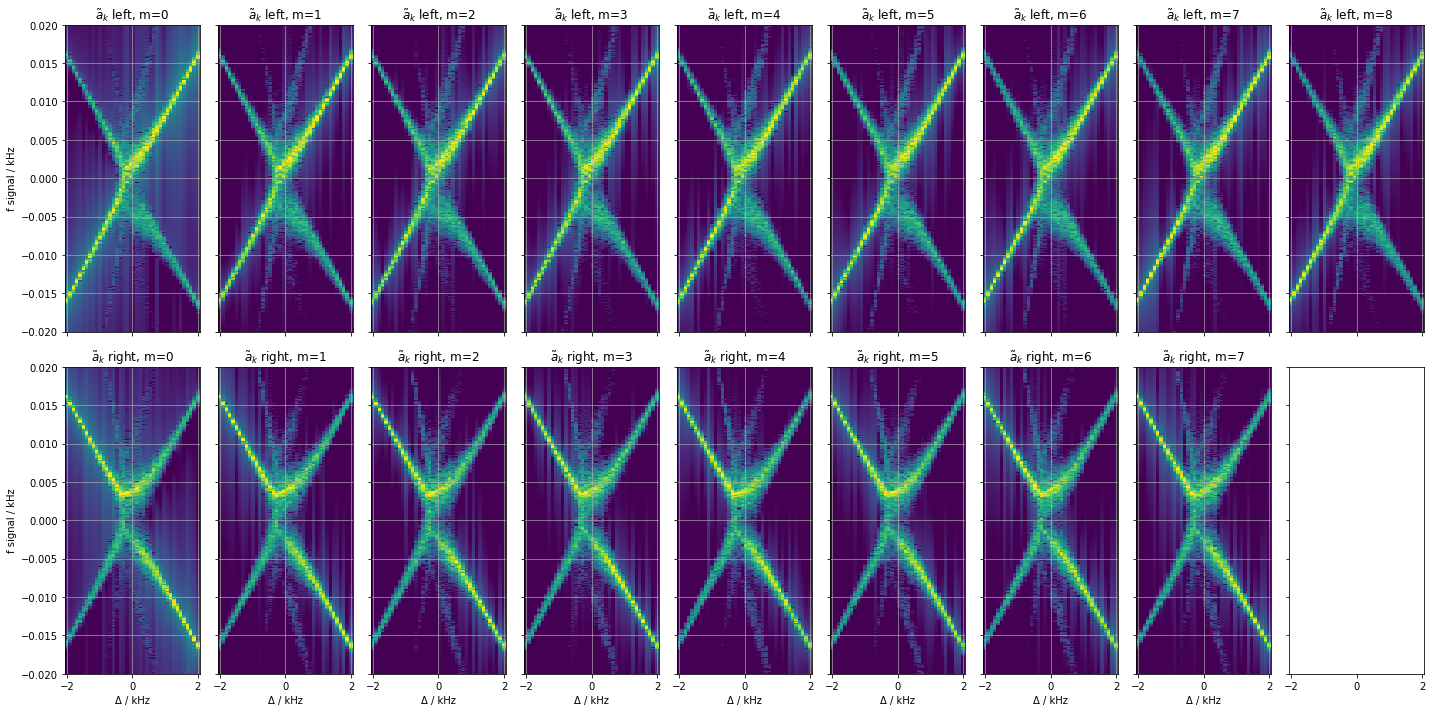

In [597]:
def scan_to_k_space(ys):
    """Work on last axis with structure (a1, b1, a2, b2, a3, b3, ...)"""
    lefta, righta = ys[...,::4], ys[...,2::4]
    #leftb, rightb = ys[...,1::4], ys[...,3::4]
    return ( # fft uses by default last axis
        fft(lefta, norm='ortho'),
        fft(righta, norm='ortho'),
    )

# structure of ys:
# axis 0: Δs,
# axis 1: ts,
# axis 2: xs (a1, b1, a2, b2, a3, b3, ...)

# Fourier transform time (axis 1)
# Fourier transform space along unit cells (axis 2)
lefta, righta = scan_to_k_space(
    fftshift(fft(ys * np.hamming(ys.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
fftbins = fftshift(fftfreq(ys.shape[1]))

print(lefta.shape, righta.shape)
vmin, vmax = 0, 3.5

n = l // 2 + l % 2
fig, axs = plt.subplots(nrows=2, ncols=n, figsize=(20, 10), sharey=True, sharex=True)
for m in range(n):
    if m < lefta.shape[-1]:
        axs[0, m].pcolormesh(Δs, fftbins, np.log10(np.absolute(lefta[:, :, m])).T,
            cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
        axs[0, m].set_ylim(-0.02, 0.02)
        axs[0, m].set_title(f"$\\tilde a_k$ left, m={m}")
        axs[0, m].grid(alpha=0.8)
    if m < righta.shape[-1]:
        axs[1, m].pcolormesh(Δs, fftbins, np.log10(np.absolute(righta[:, :, m])).T,
            cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
        axs[1, m].set_ylim(-0.02, 0.02)
        axs[1, m].set_title(f"$\\tilde a_k$ right, m={m}")
        axs[1, m].set_xlabel('Δ / kHz')
        axs[1, m].grid(alpha=0.8)
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    #axs[link,x].set_xlim(np.min(Δs), np.max(Δs))
axs[0,0].set_ylabel('f signal / kHz')
axs[1,0].set_ylabel('f signal / kHz')
#axs[-1,-1].axis('off')
plt.tight_layout()
#plt.savefig('/home/hannes/plot.png')

### Undo rotating frame
$$a_\text{worf} = e^{i(\bar\omega + (-1)^x \Delta/2)\tau} a_\text{rot} = e^{i(\omega + (-1)^x \delta/2) t} a_\text{rot}$$
$$V = \frac{1}{C} Q = V_0 \bar{Q} = V_0 \sqrt{2 \omega/\omega_0}\, \mathrm{Re}(a_\text{worf})$$

plot $a_\text{part} = e^{(-1)^x i\delta t/2} a_\text{rot}$

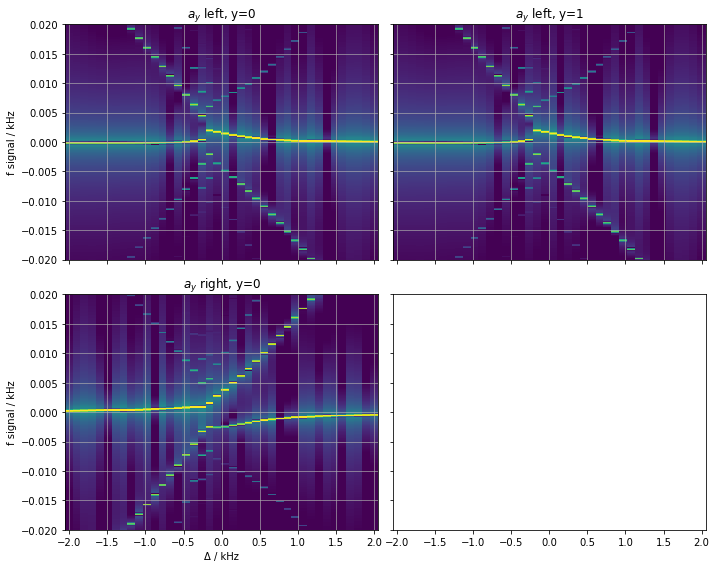

In [14]:
ωo0, ωl0, ωe0 = 30e3, 60e3, 90e3
ω0 = (ωo0 + ωe0) / 2
δs = Δs * ω0
ωl = ωl0 + δs

apart = ys[...,::2].copy()
apart[...,::2] = apart[...,::2] * np.exp(-1j * Δs[:,np.newaxis]/2 * ts[np.newaxis,:])[...,np.newaxis]
apart[...,1::2] = apart[...,1::2] * np.exp(+1j * Δs[:,np.newaxis]/2 * ts[np.newaxis,:])[...,np.newaxis]
fftapart = np.absolute(fftshift(fft(apart * np.hamming(apart.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
fftbins = fftshift(fftfreq(apart.shape[1]))

vmin, vmax = 0, 3.5

n = apart.shape[-1] // 2 + apart.shape[-1] % 2
fig, axs = plt.subplots(nrows=2, ncols=n, figsize=(10, 8), sharey=True, sharex=True)
for m in range(n):
    if 2*m < apart.shape[-1]:
        axs[0, m].pcolormesh(Δs, fftbins, np.log10(np.absolute(fftapart[:, :, 2*m])).T,
            cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
        axs[0, m].set_ylim(-0.02, 0.02)
        axs[0, m].set_title(f"$a_y$ left, y={m}")
        axs[0, m].grid(alpha=0.8)
    if 2*m+1 < apart.shape[-1]:
        axs[1, m].pcolormesh(Δs, fftbins, np.log10(np.absolute(fftapart[:, :, 2*m+1])).T,
            cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
        axs[1, m].set_ylim(-0.02, 0.02)
        axs[1, m].set_title(f"$a_y$ right, y={m}")
        axs[1, m].set_xlabel('Δ / kHz')
        axs[1, m].grid(alpha=0.8)
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    #axs[link,x].set_xlim(np.min(Δs), np.max(Δs))
axs[0,0].set_ylabel('f signal / kHz')
axs[1,0].set_ylabel('f signal / kHz')
#axs[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

In [ ]:
ωo0, ωl0, ωe0 = 30e3, 60e3, 90e3
ω0 = (ωo0 + ωe0) / 2
δs = Δs * ω0
ωl = ωl0 + δs

apart = ys[...,::2].copy()
apart[...,::2] = apart[...,::2] * np.exp(-1j * Δs[:,np.newaxis]/2 * ts[np.newaxis,:])[...,np.newaxis]
apart[...,1::2] = apart[...,1::2] * np.exp(+1j * Δs[:,np.newaxis]/2 * ts[np.newaxis,:])[...,np.newaxis]
fftapart = np.absolute(fftshift(fft(apart * np.hamming(apart.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
fftbins = fftshift(fftfreq(apart.shape[1]))

vmin, vmax = 0, 3.5

n = apart.shape[-1] // 2 + apart.shape[-1] % 2
fig, axs = plt.subplots(nrows=2, ncols=n, figsize=(10, 8), sharey=True, sharex=True)
for m in range(n):
    if 2*m < apart.shape[-1]:
        axs[0, m].pcolormesh(Δs, fftbins, np.log10(np.absolute(fftapart[:, :, 2*m])).T,
            cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
        axs[0, m].set_ylim(-0.02, 0.02)
        axs[0, m].set_title(f"$a_y$ left, y={m}")
        axs[0, m].grid(alpha=0.8)
    if 2*m+1 < apart.shape[-1]:
        axs[1, m].pcolormesh(Δs, fftbins, np.log10(np.absolute(fftapart[:, :, 2*m+1])).T,
            cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
        axs[1, m].set_ylim(-0.02, 0.02)
        axs[1, m].set_title(f"$a_y$ right, y={m}")
        axs[1, m].set_xlabel('Δ / kHz')
        axs[1, m].grid(alpha=0.8)
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    #axs[link,x].set_xlim(np.min(Δs), np.max(Δs))
axs[0,0].set_ylabel('f signal / kHz')
axs[1,0].set_ylabel('f signal / kHz')
#axs[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

## Scan one δ
Beforehand run 'scan one fδ' from circuit EOMs to get fδs.

In [8]:
print(fδs)

fschain = fs(fδs)
Δs = ftoΔ(fschain)
print(Δs)

[-3000.         -2684.21052632 -2368.42105263 -2052.63157895
 -1736.84210526 -1421.05263158 -1105.26315789  -789.47368421
  -473.68421053  -157.89473684   157.89473684   473.68421053
   789.47368421  1105.26315789  1421.05263158  1736.84210526
  2052.63157895  2368.42105263  2684.21052632  3000.        ]
(20, 5) (20, 2) (20, 3)
[[-0.05       -0.05        0.        ]
 [-0.04473684 -0.04473684  0.        ]
 [-0.03947368 -0.03947368  0.        ]
 [-0.03421053 -0.03421053  0.        ]
 [-0.02894737 -0.02894737  0.        ]
 [-0.02368421 -0.02368421  0.        ]
 [-0.01842105 -0.01842105  0.        ]
 [-0.01315789 -0.01315789  0.        ]
 [-0.00789474 -0.00789474  0.        ]
 [-0.00263158 -0.00263158  0.        ]
 [ 0.00263158  0.00263158  0.        ]
 [ 0.00789474  0.00789474  0.        ]
 [ 0.01315789  0.01315789  0.        ]
 [ 0.01842105  0.01842105  0.        ]
 [ 0.02368421  0.02368421  0.        ]
 [ 0.02894737  0.02894737  0.        ]
 [ 0.03421053  0.03421053  0.        ]
 [ 0.03

In [9]:
ains = Vtoain(np.repeat(1, 5)[np.newaxis,:], fschain)
print(ains)

[[0.+1.j         0.+0.72547625j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.72347493j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.72149009j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.71952149j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.71756892j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.71563215j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.71371099j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.71180522j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.70991463j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.70803903j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.70617821j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.70433199j 0.+0.57735027j 0.+0.70710678j
  0.+1.j        ]
 [0.+1.j         0.+0.70250017j 0.+0.577

In [13]:
Ωs = ftoΩ(fschain, Vref=10)
print(Ωs)

[[0.01492167 0.01530931]
 [0.01496295 0.01530931]
 [0.01500411 0.01530931]
 [0.01504516 0.01530931]
 [0.0150861  0.01530931]
 [0.01512693 0.01530931]
 [0.01516765 0.01530931]
 [0.01520826 0.01530931]
 [0.01524876 0.01530931]
 [0.01528915 0.01530931]
 [0.01532944 0.01530931]
 [0.01536962 0.01530931]
 [0.0154097  0.01530931]
 [0.01544967 0.01530931]
 [0.01548954 0.01530931]
 [0.01552931 0.01530931]
 [0.01556898 0.01530931]
 [0.01560854 0.01530931]
 [0.01564801 0.01530931]
 [0.01568738 0.01530931]]


In [14]:
np.min(Ωs), np.max(Ωs)

(0.014921670482891652, 0.015687375497513915)

Simulate:

In [15]:
from scipy.fft import fft, fftfreq, fftshift

τs = np.linspace(0, 3000, 30000) # dimensionless
ys = np.array([run_complex(τs, ain, Δ, Ω) for ain, Δ, Ω in zip(ains, Δs, Ωs)])
print(ys.shape)

(20, 30000, 5)


Convert back to dimensionful coordinates:
$$a_\text{worf} = e^{i(\bar\omega + (-1)^x \Delta/2)\tau} a_\text{rot}$$
$$b_\text{worf} = e^{i \bar\omega^\prime \tau} b_\text{rot}$$

(20, 5) (20, 3)
(20, 5) (20, 30000, 5)


<IPython.core.display.Javascript object>


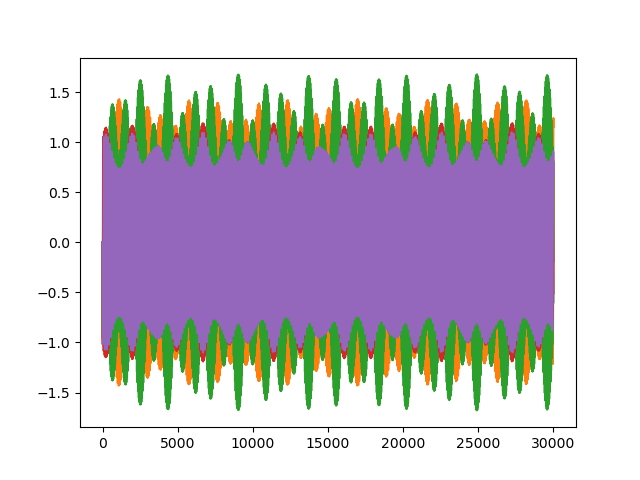

In [16]:
print(fschain.shape, Δs.shape)

# undo rotating frame
ωframe = fschain / 60e3
ωframe[...,0] -= Δs[...,0]/2 # x = 1
ωframe[...,2] += Δs[...,1]/2 # x = 1
ωframe[...,4] += Δs[...,2]/2 # x = 1
ys_worf = ys * np.exp(1j * ωframe[:,np.newaxis,:] * τs[np.newaxis,:,np.newaxis])
print(ωframe.shape, ys_worf.shape)
Vs = atoV(ys_worf, fschain[:,np.newaxis,:])

samplespacing = (τs[1] - τs[0]) / (2*np.pi * 60e3)
fftV = np.absolute(rfft(Vs * np.hamming(Vs.shape[1])[np.newaxis,:,np.newaxis], axis=1) * samplespacing)
fbins = rfftfreq(Vs.shape[1], samplespacing)

plt.figure()
plt.plot(Vs[0])

<IPython.core.display.Javascript object>


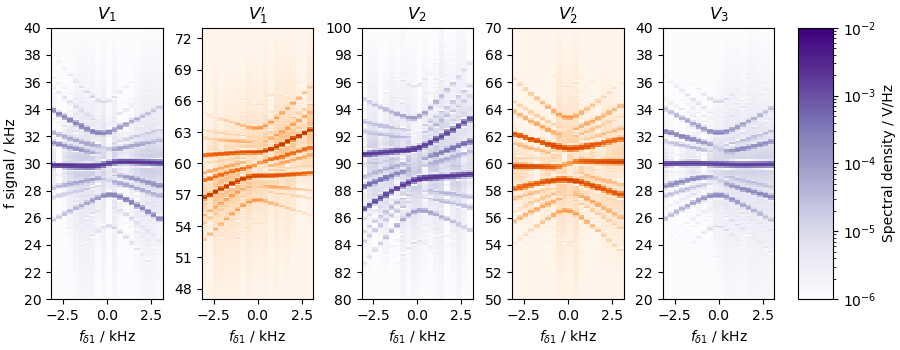

In [17]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs(fδs)[:,i]
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    #axs[i].set_ylim((-frange)/1e3, (+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('$f_{\delta 1}$ / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz')
plt.savefig('/home/hannes/plot.png', dpi=500)

### Conservation

In [295]:
fs(fδs)[0]

array([30000., 57000., 90000., 60000., 30000.])

In [309]:
print(Gham.shape)
print(np.min(Gham, axis=1)*1e9)
print(np.max(Gham,axis=1)*1e9)

(3, 30000)
[10.18087842 26.44503408  9.99999984]
[10.18088328 26.57741136 10.00000651]


1105.2631578947367


<IPython.core.display.Javascript object>


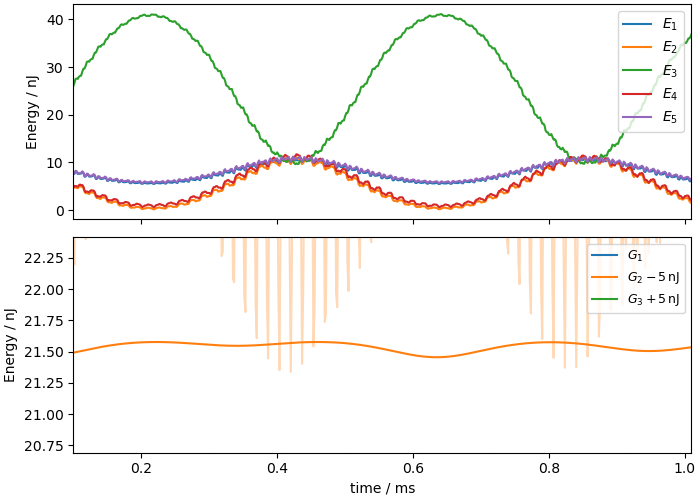

In [312]:
fδidx = 13
print(fδs[fδidx])

H0 = 20e-9 * 1**2
tham = τs / (2*np.pi * 60e3)
Gtotham = Gtot(ys[fδidx]) * H0
Gham = np.array([Gx(ys[fδidx], i+1) for i in range(3)]) * H0

#tcirc = tlin
##Ecirc, Etotcirc = E, Etot = energies(resultphi[fδidx], resultV[fδidx], resultL[fδidx], C=20e-9)
#Gtotcirc = Eglob = Gtot(E, fs(fδs[fδidx]))
#Gcirc = G = Gxs(E, fs(fδs[fδidx]))

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(7,5), constrained_layout=True)
for i in range(Ecirc.shape[-1]):
    axs[0].plot(tlin*1e3, Ecirc[:,i]*1e9, '-', label=f"$E_{i+1}$")
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Energy / nJ')

for i, shift in enumerate([0, -5, +5]):
    axs[1].plot(tlin*1e3, Gcirc[:,i]*1e9+shift, '-', color='C%d'%i, alpha=0.3)#, label=f"$G_{i+1}^\mathrm{{KCL}}$")
    axs[1].plot(tham*1e3, Gham[i]*1e9+shift, '-', color='C%d'%i, label=f"$G_{i+1}"+(r"%+d\,\mathrm{nJ}"%shift if shift else "")+"$")
    axs[1].legend(fontsize=9, loc='upper right')
#axs[1].plot(tham*1e3, Gham.T*1e9, '--')
#axs[1].plot(tlin*1e3, Etotcirc*1e9, '-')
#axs[1].plot(tlin*1e3, Gtotcirc*1e9, '-')
axs[1].set_ylabel("Energy / nJ")
axs[1].set_xlabel("time / ms")
axs[1].set_xlim(tlin[0]*1e3, tlin[-1]*1e3)
plt.savefig('/home/hannes/plot.pdf')

## Conservation

In [24]:
Δ, Ω

(0.016666666666666666, 0.00106)

<IPython.core.display.Javascript object>


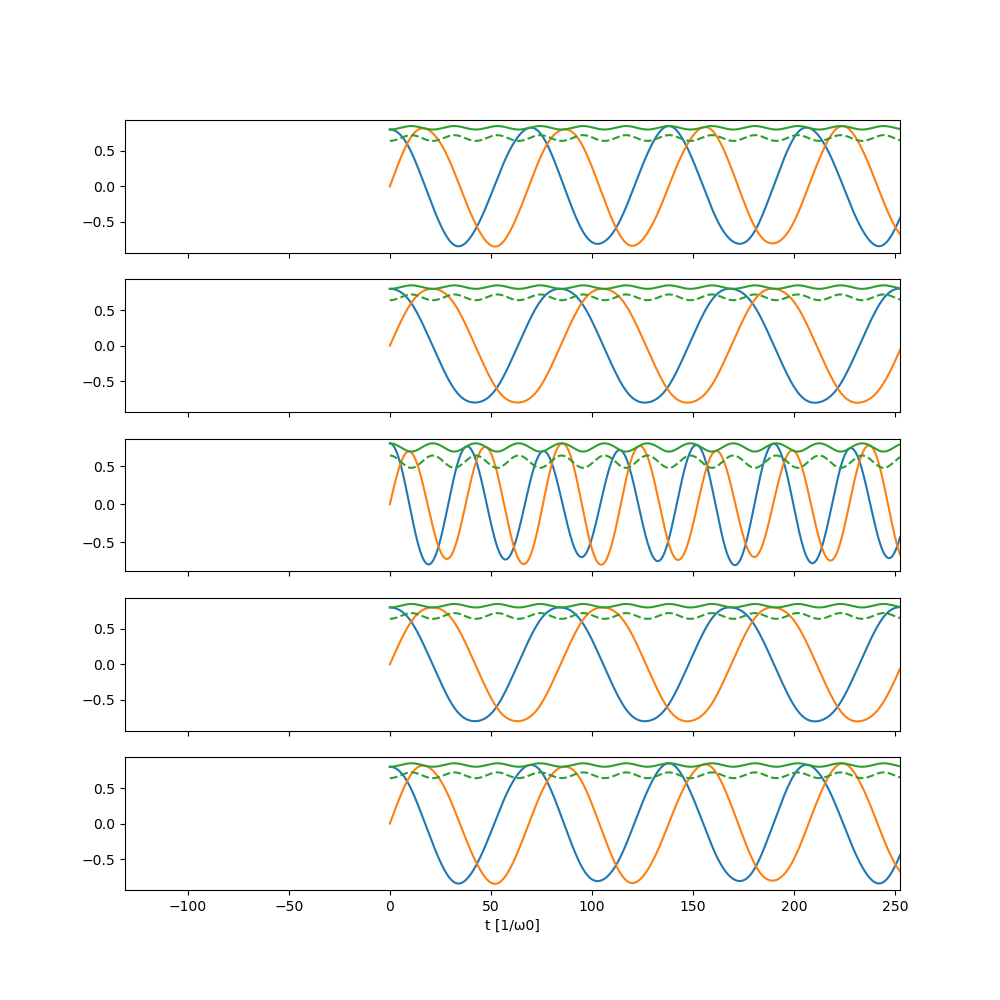

In [46]:
l = 3
ts = np.linspace(0, 10000, 100000)
Δ, Ω = 2e3/60e3, 0.1

y0 = 0.8 * np.full(2*l-1, 1, dtype=complex)
#y0 = np.exp(1j * np.random.uniform(0, 2*np.pi, 2*l-1))

ys = run_complex(ts, y0, Δ, Ω)

fig, axs = plt.subplots(nrows=ys.shape[1], figsize=(10, 10), sharex=True)
for i in range(ys.shape[1]):
    axs[i].plot(ts, np.real(ys[:,i]), color='C0')
    axs[i].plot(ts, np.imag(ys[:,i]), color='C1')
    axs[i].plot(ts, np.absolute(ys[:,i]), color='C2')
    axs[i].plot(ts, np.absolute(ys[:,i])**2, '--', color='C2')
axs[-1].set_xlabel('t [1/ω0]');

In [49]:
def Gtot(ys):
    G = np.sum(np.conj(ys[...,::2]) * ys[...,::2], axis=-1)
    assert np.allclose(G.imag, 0)
    return G.real

def Gx(ys, x): # x starting from 1
    i = x - 1 # i starting from 0
    G = np.conj(ys[...,2*i]) * ys[...,2*i]
    if 2*i > 0:
        G += (-1)**x * np.conj(ys[...,2*i-1]) * ys[...,2*i-1]
    if 2*i < ys.shape[-1]-1:
        G += (-1)**x * np.conj(ys[...,2*i+1]) * ys[...,2*i+1]
    assert np.allclose(G.imag, 0)
    return G.real

In [11]:
Gx(ys, 0).shape

(100000,)

<IPython.core.display.Javascript object>


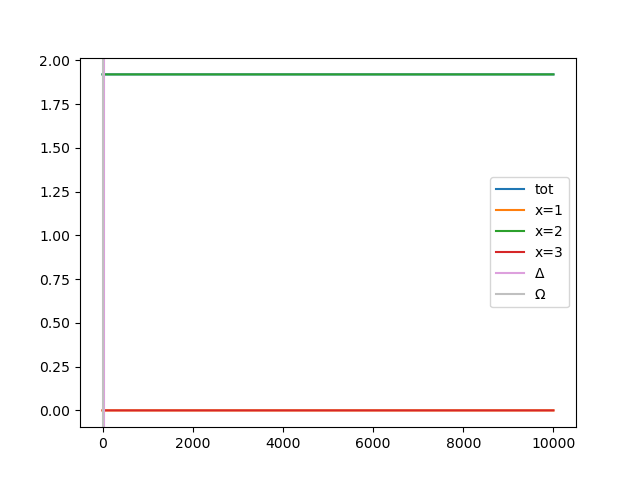

In [50]:
plt.figure()
plt.plot(ts, Gtot(ys), label='tot')
plt.plot(ts, Gx(ys, 1), label='x=1')
plt.plot(ts, Gx(ys, 2), label='x=2')
plt.plot(ts, Gx(ys, 3), label='x=3')
plt.axvline(1/Δ, label='Δ', color='plum')
plt.axvline(1/Ω, label='Ω', color='silver')
plt.legend()

## Parameter space Δ, Ω

## Scan Iω
Complex variable:
$$ a = \frac{1}{\sqrt{2}} (\bar Q + i \bar \omega_x \bar \Phi) $$
Currents inside tank circuit, not external (for small driving):
$$ I_\text{int} = \frac{1}{L} \Phi = \frac{1}{L} \Phi_0 \bar\Phi = \frac{V_0}{L\omega_0} \bar\Phi = \frac{\sqrt{2} V_0}{L\omega_0}\mathrm{Im} a $$
For external currents, see shape of original equations of motion:
$$ I_\text{ext} = \frac{1}{L} \Phi + C \ddot\Phi = \frac{1}{L} \Phi + \dot Q $$
Hamilton's equations have on the left hand side
$$ \frac{\mathrm d a}{\mathrm d \tau} = \frac{1}{\omega_0} \dot a = \frac{1}{\sqrt{2}\omega_0} (\dot Q / Q_0 + i \omega_x/\omega_0 \dot \Phi / \Phi_0)
= \frac{1}{\sqrt{2} \omega_0 V_0} (\dot Q / C_\Sigma + i \omega_x \dot \Phi)
= \frac{1}{\sqrt{2} \omega_0 V_0} (I / C_\Sigma + i \omega_x V) $$

So for an external current we add to the equations of motion
$$ \frac{\mathrm d a}{\mathrm d \tau} = a + \lambda(a) - \frac{\mathrm d a_\text{ext}}{\mathrm d \tau}, \qquad
\frac{\mathrm d a_\text{ext}}{\mathrm d \tau} = \frac{1}{\sqrt{2} \omega_0 Q_0} I_\text{ext} = \frac{1}{\sqrt{2} \omega_0 V_0 C_\Sigma} I_\text{ext}$$
with $Q_0=1\mathrm{V} \cdot 20\mathrm{nF}$, $\omega_0=60\mathrm{kHz}$ and $I=0.1\mathrm{mA}$.

Note that Hamiltonian is in rotating frame, so zero frequency of I is relative to uncoupled frequency of site!

In [23]:
from scipy.fft import fft, fftfreq, fftshift

l = 3
Ω = 0.1
Δ = np.array([1e3, 1e3, 2.7e3]) / 60e3

Iext = 0.1e-3 # mA
Iωs = np.linspace(-5e3, 5e3, 50) / 60e3

ts = np.linspace(0, 1500, 10000)
y0 = np.array([0, 0.75j, 0.59j, 0.75j, 0.98]) * 0.5

ys = []
for Iω in Iωs:
    Iωchain = np.zeros(2*l-1)
    Iωchain[0] = Iω
    ys.append(run_complex(ts, y0, Δ, Ω, Iωchain, Ibar(Iext, 30e3)))
ys = np.array(ys)

fftys = np.absolute(fftshift(fft(ys * np.hamming(ys.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
fftbins = fftshift(fftfreq(ys.shape[1], ts[1]-ts[0]))

<IPython.core.display.Javascript object>


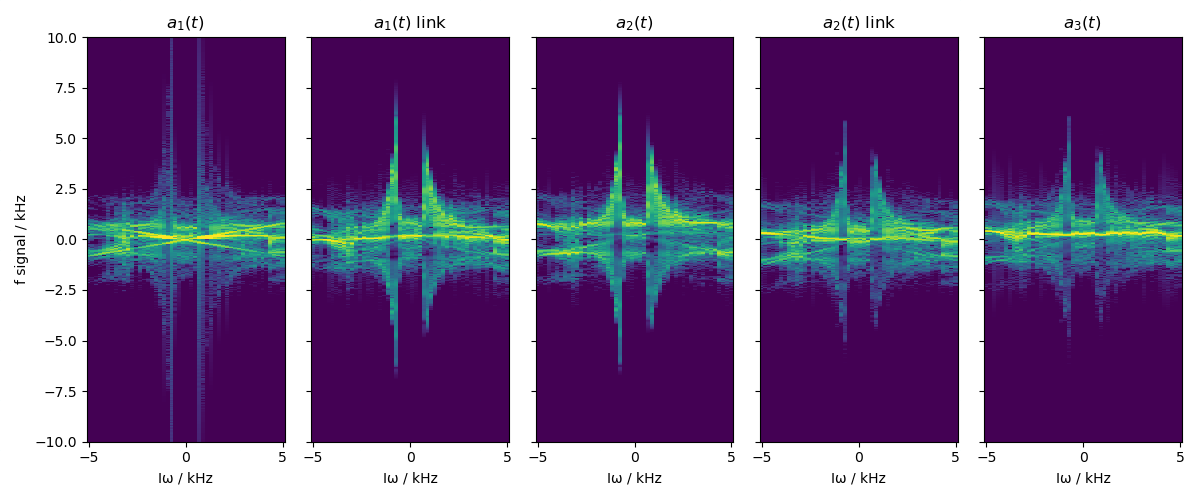

In [25]:
vmin, vmax = 0.1, 3.3

fig, axs = plt.subplots(ncols=2*l-1, figsize=(12, 5), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    axs[i].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[i].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    axs[i].set_xlabel('Iω / kHz')
    #axs[i].grid(alpha=0.7)
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png', dpi=600)

<IPython.core.display.Javascript object>


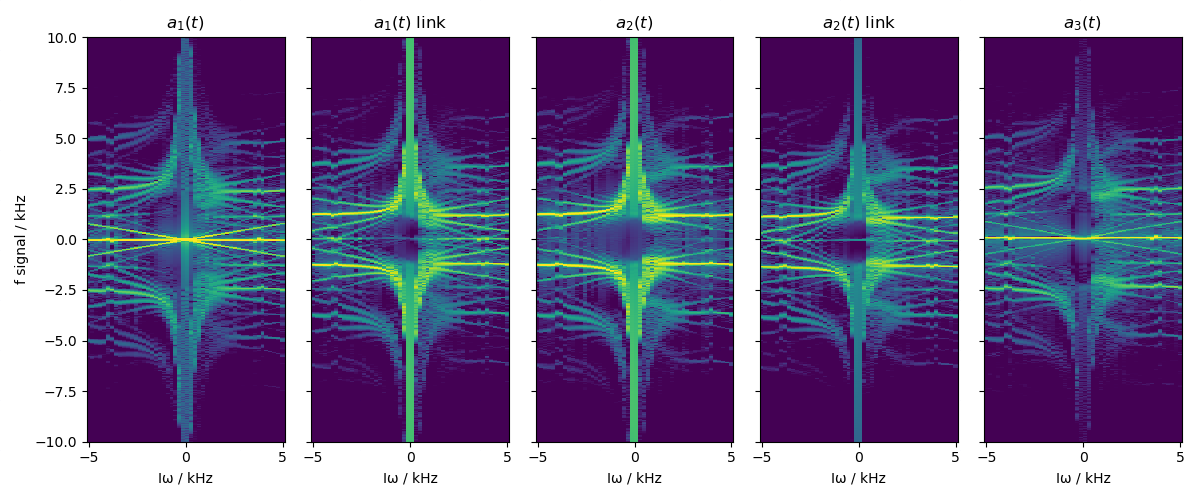

In [34]:
vmin, vmax = 0.1, 3.3

fig, axs = plt.subplots(ncols=2*l-1, figsize=(12, 5), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    axs[i].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[i].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    axs[i].set_xlabel('Iω / kHz')
    #axs[i].grid(alpha=0.7)
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


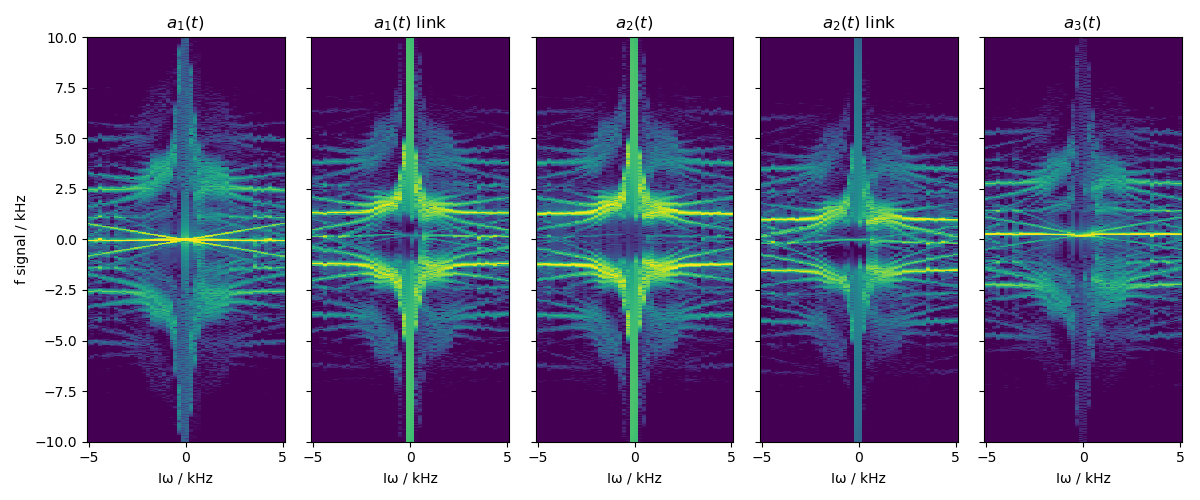

In [32]:
vmin, vmax = 0.1, 3.3

fig, axs = plt.subplots(ncols=2*l-1, figsize=(12, 5), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    axs[i].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[i].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    axs[i].set_xlabel('Iω / kHz')
    #axs[i].grid(alpha=0.7)
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


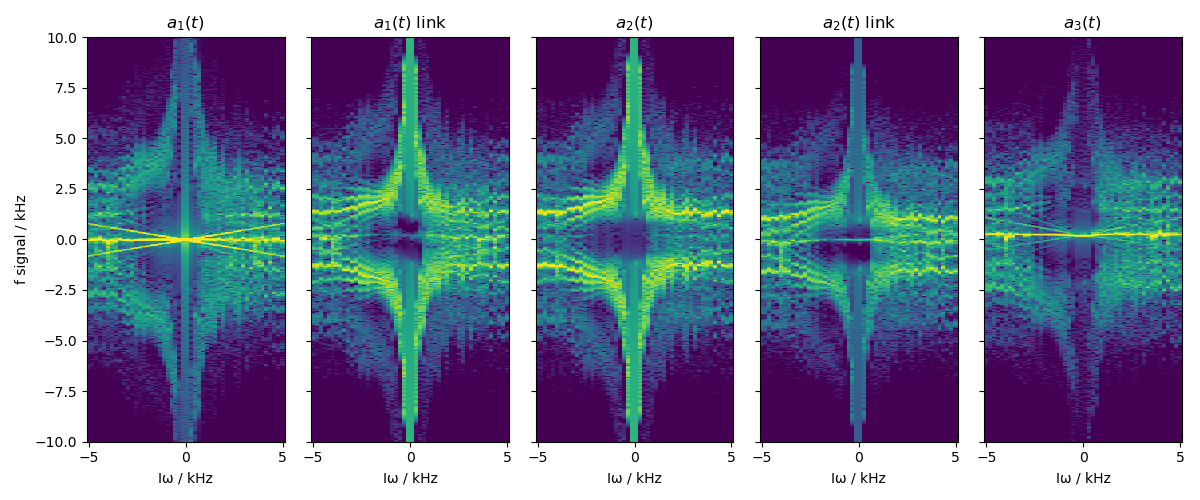

In [30]:
vmin, vmax = 0.1, 3.3

fig, axs = plt.subplots(ncols=2*l-1, figsize=(12, 5), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    axs[i].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[i].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    axs[i].set_xlabel('Iω / kHz')
    #axs[i].grid(alpha=0.7)
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


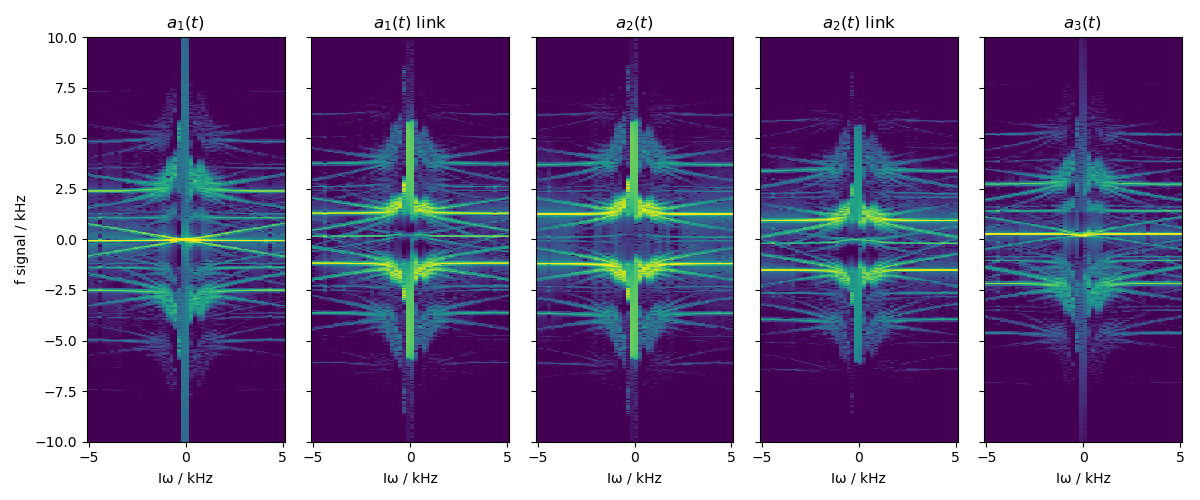

In [28]:
vmin, vmax = 0.1, 3.3

fig, axs = plt.subplots(ncols=2*l-1, figsize=(12, 5), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    axs[i].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[i].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    axs[i].set_xlabel('Iω / kHz')
    #axs[i].grid(alpha=0.7)
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


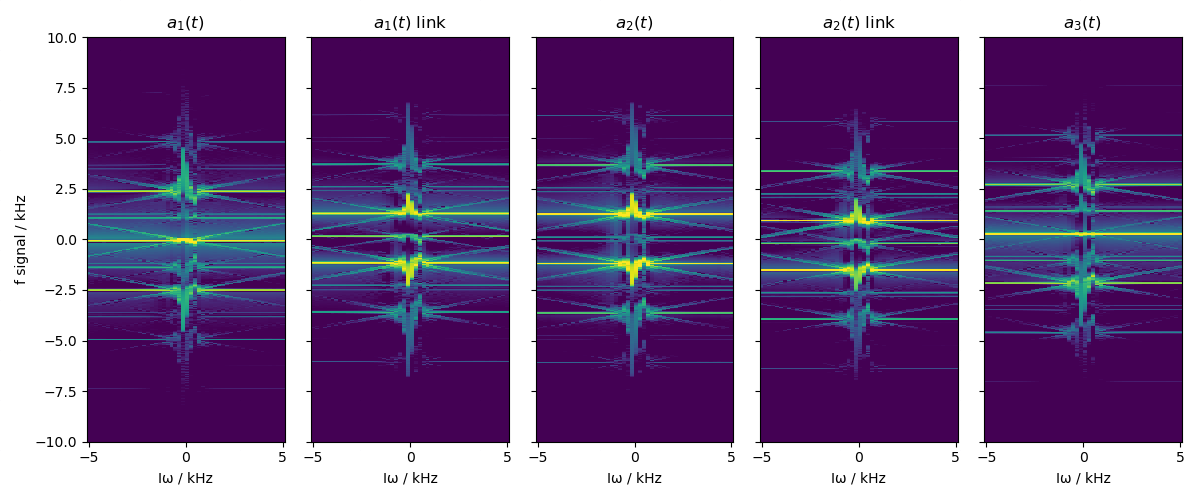

In [24]:
vmin, vmax = 0.2, 3

fig, axs = plt.subplots(ncols=2*l-1, figsize=(12, 5), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    axs[i].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[i].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    axs[i].set_xlabel('Iω / kHz')
    #axs[i].grid(alpha=0.7)
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

<IPython.core.display.Javascript object>


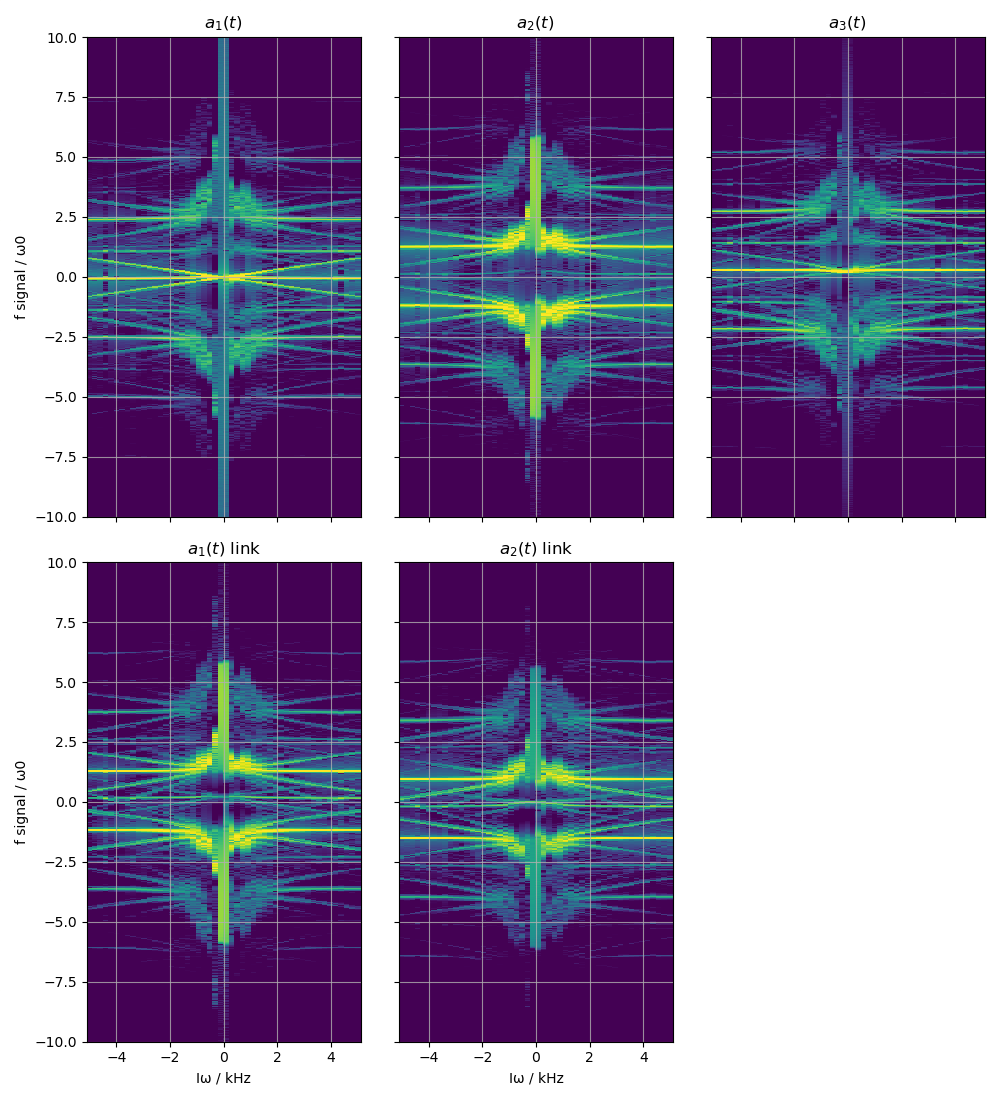

In [19]:
vmin, vmax = 0.2, 3

fig, axs = plt.subplots(nrows=2, ncols=l, figsize=(10, 11), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    x = i//2 # 0 offset
    link = i % 2
    axs[link,x].pcolormesh(
        Iωs*60, fftbins * 60, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[link,x].set_ylim(-10, 10)
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[link,x].set_title(f"$a_{i//2+1}(t)$ {'link' if i%2==1 else ''}")
    if link:
        axs[link,x].set_xlabel('Iω / kHz')
    axs[link,x].grid(alpha=0.8)
axs[0,0].set_ylabel('f signal / ω0')
axs[1,0].set_ylabel('f signal / ω0')
axs[-1,-1].axis('off')
#plt.suptitle(f"Iext={Iext*1e3:.3f}mA,   Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

## Scan Iamp

In [203]:
from scipy.fft import fft, fftfreq, fftshift

l = 3
Ω = 0.106
Δ = 1e3 / 60e3

Iexts = np.logspace(-5, -3, 50) # A

Iωchain = np.zeros(2*l-1)
Iωchain[0] = -2e3 / 60e3

ts = np.linspace(0, 1500, 10000)
y0 = np.full(2*l-1, 1, dtype=complex) * 0.9

ys = []
for Iext in Iexts:
    ys.append(run_complex(ts, y0, Δ, Ω, Iωchain, Ibar(Iext, 30e3)))
ys = np.array(ys)

fftys = np.absolute(fftshift(fft(ys * np.hamming(ys.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
fftbins = fftshift(fftfreq(ys.shape[1]))

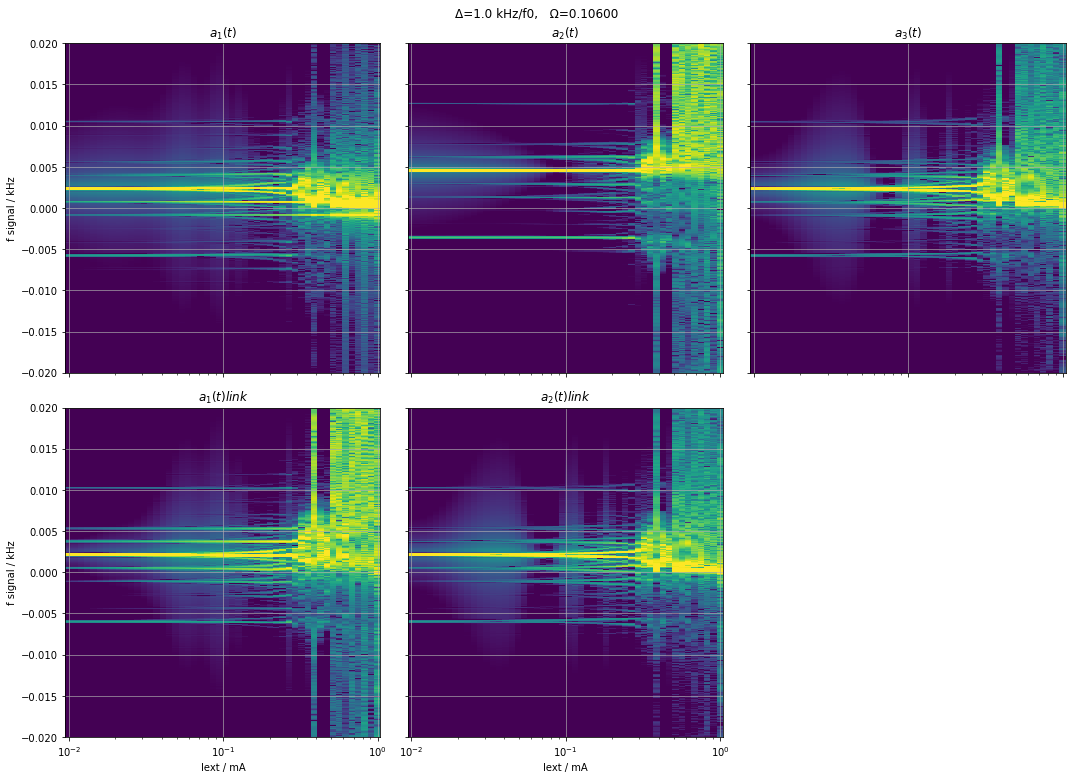

In [205]:
vmin, vmax = 0.2, 3

fig, axs = plt.subplots(nrows=2, ncols=l, figsize=(15, 11), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    x = i//2 # 0 offset
    link = i % 2
    axs[link,x].pcolormesh(
        Iexts*1e3, fftbins, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[link,x].set_ylim(-0.02, 0.02)
    axs[link,x].set_xscale('log')
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[link,x].set_title(f"$a_{i//2+1}(t){'link' if i%2==1 else ''}$")
    if link:
        axs[link,x].set_xlabel('Iext / mA')
    axs[link,x].grid(alpha=0.8)
axs[0,0].set_ylabel('f signal / kHz')
axs[1,0].set_ylabel('f signal / kHz')
axs[-1,-1].axis('off')
plt.suptitle(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

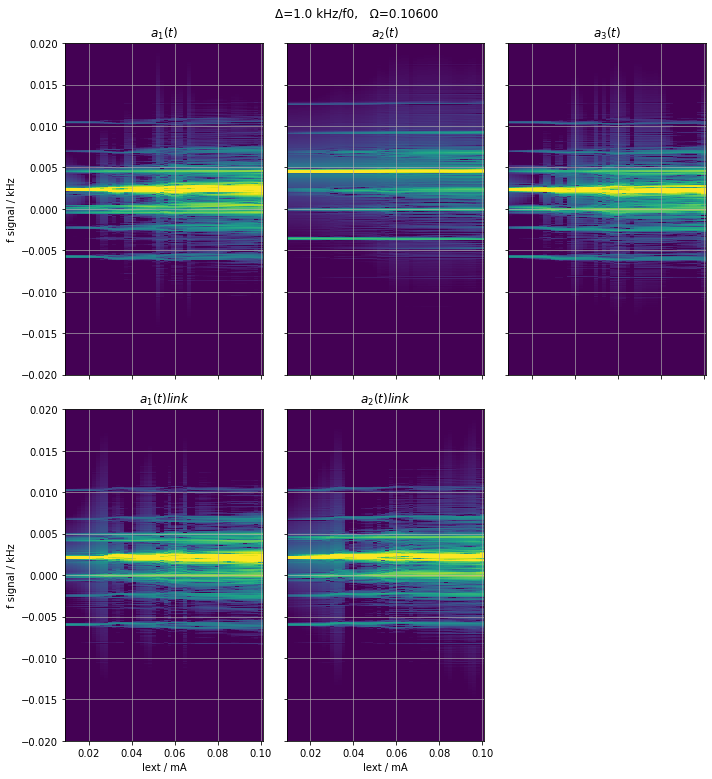

In [184]:
vmin, vmax = 0.2, 3

fig, axs = plt.subplots(nrows=2, ncols=l, figsize=(10, 11), sharey=True, sharex=True)
for i in range(ys.shape[2]):
    x = i//2 # 0 offset
    link = i % 2
    axs[link,x].pcolormesh(
        Iexts*1e3, fftbins, np.log10(fftys[:, :, i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    
    #axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[link,x].set_ylim(-0.02, 0.02)
    axs[link,x].set_xscale('log')
    #axs[link,x].set_xlim(np.min(Iωs), np.max(Iωs))
    axs[link,x].set_title(f"$a_{i//2+1}(t){'link' if i%2==1 else ''}$")
    if link:
        axs[link,x].set_xlabel('Iext / mA')
    axs[link,x].grid(alpha=0.8)
axs[0,0].set_ylabel('f signal / kHz')
axs[1,0].set_ylabel('f signal / kHz')
axs[-1,-1].axis('off')
plt.suptitle(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()
plt.savefig('/home/hannes/plot.png')

## Parameter space for ext driving

In [206]:
from scipy.fft import fft, fftfreq, fftshift

l = 3
Ω = 0.106
Δ = 1e3 / 60e3 # = ω / ω0 = f / f0

Idrives = np.logspace(np.log10(1e-5), np.log10(1e-3), 30) # A
fdrives = np.linspace(-10e3, 10e3, 20) # Hz

ts = np.linspace(0, 2000, 2000)
y0 = np.full(2*l-1, 1, dtype=complex)

limit = 5
tviol = np.full((fdrives.size, Idrives.size), np.nan)
results = np.full((fdrives.size, Idrives.size, ts.size, y0.size), np.nan, dtype=complex)
err = []
for i, fdrv in enumerate(fdrives):
    for j, Idrv in enumerate(Idrives):
        print(Idrv, fdrv)
        Iωchain = np.zeros(2*l-1)
        Iωchain[0] = fdrv / 60e3
        try:
            ys = run_complex(ts, y0, Δ, Ω, Iωchain, Ibar(Idrv, 30e3), limit)
            results[i,j] = ys
            if np.any(np.isnan(ys)):
                err.append((Idrv, fdrv))
        except RangeViolation as e:
            tviol[i,j] = e.simulationtime
err = np.array(err)

1e-05 -10000.0
1.1721022975334793e-05 -10000.0
1.3738237958832637e-05 -10000.0
1.610262027560939e-05 -10000.0
1.8873918221350958e-05 -10000.0
2.21221629107045e-05 -10000.0
2.592943797404667e-05 -10000.0
3.039195382313195e-05 -10000.0
3.5622478902624444e-05 -10000.0
4.1753189365604006e-05 -10000.0
4.893900918477499e-05 -10000.0
5.736152510448681e-05 -10000.0
6.723357536499335e-05 -10000.0
7.880462815669905e-05 -10000.0
9.236708571873866e-05 -10000.0
0.00010826367338740541 -10000.0
0.0001268961003167922 -10000.0
0.00014873521072935117 -10000.0
0.00017433288221999874 -10000.0
0.00020433597178569417 -10000.0
0.0002395026619987486 -10000.0
0.0002807216203941176 -10000.0
0.00032903445623126676 -10000.0
0.00038566204211634724 -10000.0
0.00045203536563602405 -10000.0
0.0005298316906283707 -10000.0
0.0006210169418915617 -10000.0
0.0007278953843983146 -10000.0
0.0008531678524172806 -10000.0
0.001 -10000.0
1e-05 -8947.368421052632
1.1721022975334793e-05 -8947.368421052632
1.3738237958832637e-05 -

1.3738237958832637e-05 -2631.5789473684217
1.610262027560939e-05 -2631.5789473684217
1.8873918221350958e-05 -2631.5789473684217
2.21221629107045e-05 -2631.5789473684217
2.592943797404667e-05 -2631.5789473684217
3.039195382313195e-05 -2631.5789473684217
3.5622478902624444e-05 -2631.5789473684217
4.1753189365604006e-05 -2631.5789473684217
4.893900918477499e-05 -2631.5789473684217
5.736152510448681e-05 -2631.5789473684217
6.723357536499335e-05 -2631.5789473684217
7.880462815669905e-05 -2631.5789473684217
9.236708571873866e-05 -2631.5789473684217
0.00010826367338740541 -2631.5789473684217
0.0001268961003167922 -2631.5789473684217
0.00014873521072935117 -2631.5789473684217
0.00017433288221999874 -2631.5789473684217
0.00020433597178569417 -2631.5789473684217
0.0002395026619987486 -2631.5789473684217
0.0002807216203941176 -2631.5789473684217
0.00032903445623126676 -2631.5789473684217
0.00038566204211634724 -2631.5789473684217
0.00045203536563602405 -2631.5789473684217
0.0005298316906283707 -2

1.1721022975334793e-05 4736.842105263157
1.3738237958832637e-05 4736.842105263157
1.610262027560939e-05 4736.842105263157
1.8873918221350958e-05 4736.842105263157
2.21221629107045e-05 4736.842105263157
2.592943797404667e-05 4736.842105263157
3.039195382313195e-05 4736.842105263157
3.5622478902624444e-05 4736.842105263157
4.1753189365604006e-05 4736.842105263157
4.893900918477499e-05 4736.842105263157
5.736152510448681e-05 4736.842105263157
6.723357536499335e-05 4736.842105263157
7.880462815669905e-05 4736.842105263157
9.236708571873866e-05 4736.842105263157
0.00010826367338740541 4736.842105263157
0.0001268961003167922 4736.842105263157
0.00014873521072935117 4736.842105263157
0.00017433288221999874 4736.842105263157
0.00020433597178569417 4736.842105263157
0.0002395026619987486 4736.842105263157
0.0002807216203941176 4736.842105263157
0.00032903445623126676 4736.842105263157
0.00038566204211634724 4736.842105263157
0.00045203536563602405 4736.842105263157
0.0005298316906283707 4736.84

(20, 30)


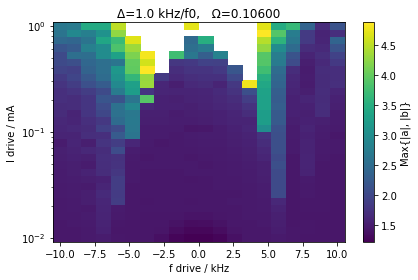

In [207]:
maxrange = np.absolute(results).max(axis=(2,3))
print(maxrange.shape)

plt.figure()
plt.pcolormesh(fdrives/1e3, Idrives*1e3, maxrange.T, shading='auto')
plt.colorbar().set_label(r'Max{|a|, |b|}')
plt.yscale('log')
plt.ylabel('I drive / mA')
plt.xlabel('f drive / kHz')
plt.title(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()

(20, 30)


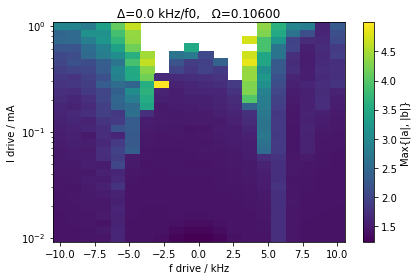

In [199]:
maxrange = np.absolute(results).max(axis=(2,3))
print(maxrange.shape)

plt.figure()
plt.pcolormesh(fdrives/1e3, Idrives*1e3, maxrange.T, shading='auto')
plt.colorbar().set_label(r'Max{|a|, |b|}')
plt.yscale('log')
plt.ylabel('I drive / mA')
plt.xlabel('f drive / kHz')
plt.title(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()

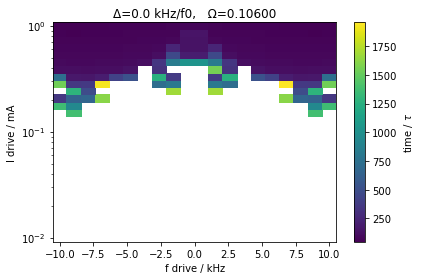

In [188]:
plt.figure()
plt.pcolormesh(fdrives/1e3, Idrives*1e3, tviol.T, shading='auto', cmap='viridis')
if err.size > 0:
    plt.scatter(err[:,0]*1e3, err[:,1]/1e3, color='red')
plt.colorbar().set_label(r'time / $\tau$')
plt.yscale('log')
plt.ylabel('I drive / mA')
plt.xlabel('f drive / kHz')
plt.title(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()

(20, 30)


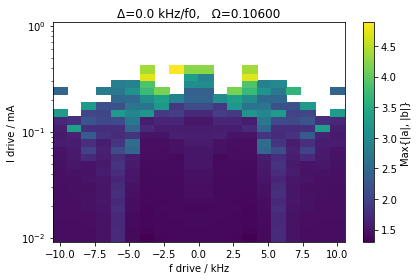

In [192]:
maxrange = np.absolute(results).max(axis=(2,3))
print(maxrange.shape)

plt.figure()
plt.pcolormesh(fdrives/1e3, Idrives*1e3, maxrange.T, shading='auto')
plt.colorbar().set_label(r'Max{|a|, |b|}')
plt.yscale('log')
plt.ylabel('I drive / mA')
plt.xlabel('f drive / kHz')
plt.title(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()

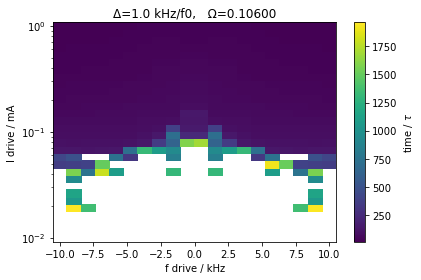

In [177]:
plt.figure()
plt.pcolormesh(fdrives/1e3, Idrives*1e3, tviol.T, shading='auto', cmap='viridis')
if err.size > 0:
    plt.scatter(err[:,0]*1e3, err[:,1]/1e3, color='red')
plt.colorbar().set_label(r'time / $\tau$')
plt.yscale('log')
plt.ylabel('I drive / mA')
plt.xlabel('f drive / kHz')
plt.title(f"Δ={Δ*60:.1f} kHz/f0,   Ω={Ω:.5f}")
plt.tight_layout()

(20, 30, 2000, 5)

-10000000.0 mA, 1e-06 kHz, good: False


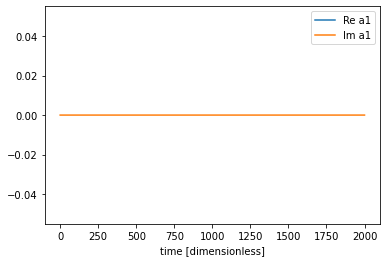

In [154]:
# Note only results of successful simulations are saved!

print(results.shape)
print()

i,j = 0, -1
print(f"{fdrives[i]*1e3} mA, {Idrives[j]/1e3} kHz, good: {not np.any(np.isnan(results[i,j,:,:]))}")

plt.figure()
plt.plot(ts, results[i,j,:,0].real, label='Re a1')
plt.plot(ts, results[i,j,:,0].imag, label='Im a1')
plt.xlabel('time [dimensionless]')
plt.legend()